In [2]:
%load_ext autoreload
%autoreload 2
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Background and Research Question

## IIA

Independence of Irrelevant Alternatives (IIA) is a principle in decision theory that states that the preference between two options should not be affected by the presence or absence of a third option that is not relevant to the decision at hand.

In the context of recommendation systems, IIA means that the ranking of items should not change based on the addition or removal of items that are not relevant to the user's preferences. In other words, if a user is given a set of items to choose from and they express a preference for one item over another, the introduction of additional items that are not relevant to their preferences should not change the relative ranking of the original items.

Simple predictive models do not account for context effects, such as the dependence of choice behavior on the set of alternatives in a choice set. However, real world user choises are usually set dependent; violating IIA.

In this study, we aim to study the relation between the learned model and the obtained user choices in its domain. Specifically, we will compare user choices under IIA vs. non-IIA prediction models, and try to observe if the learned model "cause" user choices to be more IIA, or vice versa.



## Research Question

<center>Do users make more IIA choices when using an IIA model compared to non-IIA model? If so, are user choices really set independent or is it a delusion caused by the IIA model?<center>

## Hypothesis

- We expect to observe IIA user choices in IIA domains    
- More set dependent user choices in non IIA domains    
- We expect that IIA user behavior is a delusion made by the IIA model recommendations – e.g. extreme score for chosen items?

# Part 1: IIA models vs. the pairwise ranker non-IIA model on random generated data

In the first part of the assignment, we evaluate the IIA property of the choices of different bias users using the UserModels and ContextChoiceEnvironment classes defined in WS2 and HW2 of the course. 


## User Models

In [3]:
#@title User Model
import abc
import numpy as np

class UserModel(abc.ABC):
  @abc.abstractclassmethod
  def __call__(self, X, *args):
    '''
    Given items X, calculate the user's valuation v(x) for each item x
    '''
    raise NotImplementedError()
  
  def predict(self, X, *args):
    raise NotImplementedError()

class RationalUserModel(UserModel):

  def __init__(self, beta_h):
    self.beta_h = beta_h
    self.type = "rational"

  def __call__(self, X):
    return X@self.beta_h
  
  def choice(self, X):
    return np.argmax(self(X), axis=0)

  def choice_coef(self, X):
    return self(X)


class AttractionUserModel(UserModel):
  def __init__(self, beta_h, alpha_attr):
    # rational_utility_weights
    self.rational_utility_weights = beta_h 
    # attraction_coefficient
    self.attraction_coefficient = alpha_attr
    self.name = "attraction"

  def __call__(self, X):
    # X: shape=(num_items,num_features) - Item covariates
    return (
        self._rational_decision_term(X)
        + self.attraction_coefficient*self._attraction_term(X)
    )

  def _rational_decision_term(self, X):
    return X@self.rational_utility_weights

  def _attraction_term(self, X):
    # Calculate preference vector
    preference_vector = X.max(axis=0)-X.min(axis=0)
    preference_vector_normalized = (
        preference_vector
        /np.sqrt(preference_vector@preference_vector)
    )
    # Calculate dominance and distance matrices
    N = len(X)
    dominance = np.zeros((N,N))
    distance = np.zeros((N,N))
    for i in range(N):
      for j in range(N):
        dominance[i,j] = (+1)*np.all(X[i]-X[j] >= 0) + (-1)*np.all(X[j]-X[i] >= 0)
        distance[i,j] = abs(preference_vector_normalized@(X[i]-X[j]))

    attraction_terms = (dominance*distance).sum(axis=1)
    return attraction_terms
  
  def choice(self, X):
    return np.argmax(self(X), axis=0)

  def choice_coef(self, X):
    return self(X)



class SimilarityUserModel(UserModel):

  def __init__(self, beta_h, beta_sim):
    self.beta_h = beta_h
    self.beta_sim = beta_sim
    self.name = "similarity"

  def __call__(self, X):

    # calculate actual value
    v_ih = X@self.beta_h

    # calculate perference vector
    pref_vec = X.max(axis=0) - X.min(axis=0)


    # project on the ortogonal hyperplane
    X_projected = np.zeros(X.shape)
    projection_size = np.zeros(X.shape[0])

    for i in range(X.shape[0]):
        X_projected[i, :] = X[i,:] -  (X[i,:].dot(pref_vec) / np.linalg.norm(pref_vec)) * pref_vec

    # find min distance on projected

    distances = np.zeros((X_projected.shape[0], X_projected.shape[0]))

    for i in range(X_projected.shape[0]): # could be optimized (cal half mat etc..)
      for j in range(X_projected.shape[0]):
        distances[i,j] = np.linalg.norm(X_projected[i,:] - X_projected[j,:])
    
    # avoide i == j
    distances = distances + np.eye(distances.shape[0])*distances.max()

    min_distances = distances.min(axis=1) # go over columns

    return v_ih + self.beta_sim*-min_distances
  
  def choice(self, X):
    return np.argmax(self(X))

  def choice_coef(self, X):
    return self(X)


class CompromiseUserModel(UserModel):

  def __init__(self, beta_h, beta_com):
    self.beta_h = beta_h
    self.beta_com = beta_com
    self.name = 'compromise'

  def __call__(self, X):

    # calculate rational value
    v_ih = X@self.beta_h
    # calculate compromise value
    X_com = (X.max(axis=0) + X.min(axis=0)) / 2

    # pairwise distance between rows of X and X_com
    d_im = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        d_im[i] = np.linalg.norm(X[i,:] - X_com)

    return v_ih + -d_im*self.beta_com
  
  def x_user_choice_positions(self, X):
    return np.argmax(self(X), axis=0)

  def choice(self, X):
    return np.argmax(self(X), axis=0)

  def choice_coef(self, X):
    return self(X)

## Environment Setup

In [4]:
#@title Discrete Choice Environment
import numpy as np
import pandas as pd
Counter = 0

class DiscreteChoiceEnvironment:
    """
    Generic class for discrete-choice dataset generation
    """
    n_features = 8
    observations_per_user = 10
    items_per_slate = 1
    train_user_proportion = 0.6
    

    def _generate_user_item_attributes(self, n_users):
        """
        Generate latent parameters for users and items.

        Parameters
        ----------
        n_users : int

        Output
        ------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, observations_per_user, items_per_slate, n_features)
        """
        users = np.random.normal(
            size=(
                n_users,
                self.n_features,
            ),
        )
        items = np.random.normal(
            size=(
                n_users,
                self.observations_per_user,
                self.items_per_slate,
                self.n_features,
            ),
        )
        return users, items

    def _choice(self, users, items):
        """
        Discrete choice function
        
        Parameters
        ----------
        users : ndarray of shape (n_users, n_features)
        items : ndarray of shape
                (n_users, observations_per_user, items_per_slate, n_features)

        Output
        ------
        choice : Dict[str -> ndarray of shape(n_users, observations_per_user)]
        """
        raise NotImplementedError
    
    def _generate_choice_dataset(self, n_users):
        """
        Generate choice dataset, formatted as pandas dataframe.
        """
        users, items = self._generate_user_item_attributes(n_users)
        choice_dct = self._choice(users, items)
        rows = []
        for i in range(n_users):
            for j in range(self.observations_per_user):
                dct = {}
                dct['user_id'] = f'{i}'
                dct['slate_id'] = f'{i}_{j}'
                for k in range(self.items_per_slate):
                    for l in range(self.n_features):
                        dct[f'x_{k},{l}'] = items[i,j,k,l]
                for choice_type, choice_matrix in choice_dct.items():
                    dct[choice_type] = choice_matrix[i,j]
                rows.append(dct)
        df = pd.DataFrame(rows)
        return df
    
    def generate_datasets(self, n_users):
        n_train_users = int(n_users*self.train_user_proportion)
        n_test_users = n_users - n_train_users
        return (
            self._generate_choice_dataset(n_train_users),
            self._generate_choice_dataset(n_test_users),
        )


In [5]:
#@title Context Choice Environment
import numpy as np
import pandas as pd
# from DiscreteChoiceEnv import *
# from UserModel import *

class ContextChoiceEnvironment(DiscreteChoiceEnvironment):
    """
    Dataset generator for binary choice with decision noise
    """
    def __init__(self,
                 slate_number=3,
                 observations_per_user=50,
                 num_items_omega=15):
      
        # self.noise_scale = noise_scale
        user_model = AttractionUserModel(
        beta_h=np.array([1,9]),
          alpha_attr=3,
      )

        self.user_model = user_model
        self.slate_number = slate_number
        self.observations_per_user = observations_per_user
        self._generate_ex1_items(slate_number=slate_number,
                                 num_items_omega=num_items_omega)
        self.Counter = 0


    def _generate_ex1_items(self, slate_number=3, num_items_omega=15):
      if slate_number == 1:
        self.omega = np.array([[1,3,3,4,10,4,2],[1,7.5,5,4,5,6,1]]) 
        self.E_s = np.array([10, 20, 80, 40, 30, 80, 100])
        self.omega_tag = np.array([[4,2.5,4.5],[4.5,6,5]])
        self.E_s_tag = np.array([5, 8, 3])

      elif slate_number == 2:
        self.omega = np.array([[3,8,8.5,4,10,8,2, 1],[8,7,4,4,5,6,1, 8]])
        self.E_s = np.array([10, 90, 30, 50, 30, 40,100,90])

        self.omega_tag = np.array([[4,3,4.5,6],[8,6,5,6]])
        self.E_s_tag = np.array([5, 8, 3, 9])

      else:
        np.random.seed(24) 
        num_items_omega = 15
        self.omega, self.omega_tag = list(), list()
        self.E_s, self.E_s_tag = list(), list()

        for i in range(self.observations_per_user):
          self.omega.append(np.hstack([np.zeros((num_items_omega, 1)),
                                        np.ones((num_items_omega, 1))*i,
                                        np.random.randint(
                                            20,size=(num_items_omega,2)),
                                       np.random.randint(
                                           20,100,size=(num_items_omega,1))
                                        ]
                                       )
          )
          
          self.omega_tag.append(np.hstack([np.zeros((100, 1)),
                              np.ones((100, 1))*i,
                              np.random.randint(
                                  20,size=(100,2)),
                              np.random.randint(20,size=(100,1))
                              ]
                              )
          )

        self.omega = np.vstack(self.omega).T
        self.omega_tag = np.vstack(self.omega_tag).T
        self._items_to_frame(self.omega,self.E_s, data_name="Omega")
        self._items_to_frame(self.omega_tag, self.E_s_tag, ord('I'),
                                     data_name="Omega_tag")

      return

    def _items_to_frame(self, omega, E_s, char_start=ord('A'), data_name="Omega"):

        data = pd.DataFrame(omega.T).reset_index()
        if len(data) < self.observations_per_user:
          data['user_id'] = np.zeros(len(data))
          data['slate_id'] = np.zeros(len(data))
          data['rational_user_val'] = omega.T@\
                            self.user_model.rational_utility_weights
          data["E_s"] = E_s

        else:
          data['rational_user_val'] = data.loc[:,[2,3]].values@\
                  self.user_model.rational_utility_weights

          data.rename(columns={0:'user_id', 1:'slate_id',
                               2:'x_0', 3:'x_1', 4:'E_s'},
                      inplace=True)

        data['name'] = data['index'].apply(lambda x: chr(char_start+x))
        
        if data_name == "Omega":
          self.omega_df = data
        else:
          self.omega_tag_df = data

        return data
    
    def generate_slate_data_set(self, slate_id):

          data = self.omega_df.loc[self.omega_df.slate_id == slate_id].reset_index().drop(columns=["level_0"])

          self.top_5 = data.rational_user_val.argsort()[-5:][::-1]
          # data['top_5'] = data['index'].apply(lambda x: int(x) in self.top_5.values)
          data['perceived_val'] = np.nan
          feature_cols = [col for col in data.columns if col.startswith('x')]
          data.loc[self.top_5, ['perceived_val']] = self.user_model(
              data.loc[self.top_5, feature_cols].values)
          data = self._choice(data)
          
          return data


    def inspect_data(self, items_type="current", slate_id=-1):
      
      if items_type == "current":
        data =  self._items_to_frame(self.omega,self.E_s, data_name="Omega")
      elif items_type == "tag":
        data =  self._items_to_frame(self.omega_tag, self.E_s_tag, ord('A') + len(self.E_s),
                                     data_name="Omega_tag") 
        

      return data      


    def generate_datasets(self, slate_id=-1):
      self.Counter = self.Counter + 1
      data = pd.DataFrame(self.omega.T).reset_index()
      
      if len(data) < self.observations_per_user:
        data['user_id'] = np.zeros(len(data))
        data['slate_id'] = np.zeros(len(data))
        data['name'] = data['index'].apply(lambda x: chr(ord('A')+x))
        data['rational_user_val'] = self.omega.T@\
                                    self.user_model.rational_utility_weights
        self.top_5 = data.rational_user_val.argsort()[-5:][::-1]
        # print(self.top_5)
        data['top_5'] = data['index'].apply(lambda x: x.index in self.top_5)
        data['perceived_val'] = np.nan
        data.loc[self.top_5, ['perceived_val']] = self.user_model(data.loc[self.top_5, [0,1]].values)
        res = self._choice(data)    
      
      else:
        # if slate_id != -1:
        res = self.generate_slate_data_set(slate_id)

      return res
      
    def _choice(self, data, chosen='chosen'):
        dummies = pd.get_dummies(data.index)
        # for name, group in grouped:
        self.chosen = data['perceived_val'].astype(float).idxmax()
        data[chosen] = dummies.iloc[data['perceived_val'].astype(float).idxmax(), :]
        return data

    def add_item(self, index):
      item = self.omega_tag_df.loc[self.omega_tag_df["index"] == index].copy()
      new_index = len(self.omega_df)
      item.index = [new_index]
      item['index'] = item.index
      self.omega_df = pd.concat([self.omega_df, item])
      return self.omega_df.loc[
          self.omega_df.slate_id == item.slate_id.iloc[0]]

    def drop_item(self, index):
      # to_pop = max(self.omega_df.index)
      # df_T = self.omega_df.T
      # df_T.pop(to_pop)
      # self.omega_df = df_T.T
      # return self.omega_df
      item_slate = self.omega_df.loc[self.omega_df.index == index].slate_id.iloc[0]
      self.omega_df.drop(index=index, inplace=True)
      return self.omega_df.loc[
          self.omega_df.slate_id == item_slate]
    
    def top_5_idx(self, rational_user_val):
      return rational_user_val.argsort()[-5:][::-1]


# a_user = AttractionUserModel(
#     beta_h=np.array([1,9]),
#     alpha_attr=3,
# )

# env = ContextChoiceEnvironment(user_model=a_user)
# d = env.inspect_data("current")
# env.generate_datasets(0)

In [6]:
#@title Train Context Environment

class TrainContextChoiceEnvironment(DiscreteChoiceEnvironment):
    """
    Dataset generator for binary choice with decision noise
    """
    def __init__(self,
                 observations_per_user=500,
                 num_items=7,
                 num_features=5):

        self.user_models = {
            'Attraction' : AttractionUserModel( np.arange(num_features),100),
            'Compromise' : CompromiseUserModel(np.arange(num_features), 100),
            'Similarity' : SimilarityUserModel(np.arange(num_features), 100),
            'Rational' : RationalUserModel(np.arange(num_features)),
            }

        self.observations_per_user = observations_per_user
        self.items_per_slate = num_items
        self.n_features = num_features
        self._generate_user_item_attributes(1)

    def generate_datasets(self, num_features=5, num_items=7):

          # df_train, df_test = list(), list()
          # num_slates = self.omega_df.slate_id.nunique()
          # train_slates = int(0.8*num_slates)
          
          # for slate in range(train_slates):
          #   df_train.append(self.generate_slate_data_set(slate))

          # for slate in range(train_slates, num_slates):
          #   df_test.append(self.generate_slate_data_set(slate))
          # train_data = pd.concat(df_train).drop(columns=['name', 'index',])
          # test_data = pd.concat(df_test)

          # train_label = train_data['chosen']
          # test_label = test_data['chosen']
          self.items_per_slate = num_items
          self.num_features = num_features

          train_slates = int(0.8*self.observations_per_user)
          train_data, y_train = self._generate_choice_dataset(num_features=num_features,
                                                     num_slates=train_slates,
                                                      num_items=num_items)

          test_slates = self.observations_per_user - train_slates
          test_data, y_test = self._generate_choice_dataset(num_features=num_features,
                                                    num_slates=test_slates,
                                                    num_items=num_items)



          return train_data, test_data, y_train, y_test


    def _choice(self, data):
        dummies = pd.get_dummies(range(len(data)))
        chosen = dummies[data.astype(float).argmax()]
        return chosen

    def _generate_choice_dataset(self, num_features=5, num_slates=500, num_items=7):
        """
        Generate choice dataset, formatted as pandas dataframe.
        """
        _, items = self._generate_user_item_attributes(0)
        

        y_train = {name:[] for name,user in self.user_models.items()}
        train = list()
        for i in range(num_slates):
            train.append(np.hstack(
                      [np.ones((num_items, 1))*i, # slate_id
                      np.random.normal(size=(num_items,num_features)), # data
                                                    ]))
            for name, user in self.user_models.items():
              y_train[name].append(self._choice(user(train[-1][:,1:])))
        
        feature_names = [f'x_{i}' for i in range(num_features)]
        col_names = ['slate_id'] + feature_names
        train_df = pd.DataFrame(np.vstack(train),
                                columns=col_names)

        for name, choices in y_train.items():
          train_df[name] = np.hstack(choices)

        train_data = train_df[col_names]#.drop(columns=['slate_id'])
        y = train_df[list(y_train.keys()) + ['slate_id']]
        return train_data, y

    def mean_welfare(self, X):
      return (X@np.arange(self.num_features)).mean()




# enV2 = TrainContextChoiceEnvironment(num_features=5, num_items=7)
# enV2.generate_datasets(num_features=5, num_items=7)

# add slate id to label, see which entry is value before doing so

## **Reminder** for $HW2$ settings:

----------------------------------------

**Recommendation procedure:**
1. The collection of available items is the *ground set* $\Omega=\{x_1,...,x_n\}$ ($n$ may be different in different parts of this task). Each item $x \in s$ is described by two features, $x=(x_1, x_2)$.
2. There is a single user whose (true) value function is $v(x)=\alpha^\top x$. I.e., if the user chooses item $x_i$, then she receives $\alpha_1\cdot x_{i1} + \alpha_2\cdot x_{i2}$ utility from this choice. **The value vector $\alpha$ is known to the system**.
3. System also benefits from user choices. If the user chooses item $x_i$, then the system receives $e_i$ utility. The values $e_i$ are predetermined, known to the system, and do not depend on features.
4. The system recommends to the user the top-5 items $x\in \Omega$ having highest value. We will call this the *choice set*, denoted $s \in \Omega$.
5. The user chooses exactly one item $x \in s$. This is the item with highest *perceived value*, as determined by the attraction effect:
$$
  \tilde{v}(x|s) = \alpha^\top x + \mathtt{att}(x|s)
$$
where $\mathtt{att}$ is as was defined in class. We will denote the chosen item by $y = \mathtt{argmax}_{x \in s} \tilde{v}(x|s)$.
6. User receives utility $v(y)$, and system receives utility $e_y$.

----------------------------------------


In [7]:
from collections import OrderedDict

%config InlineBackend.figure_format = 'retina'

In [8]:
env_conx = ContextChoiceEnvironment()
env_conx.inspect_data("current")

,index,user_id,slate_id,x_0,x_1,E_s,rational_user_val,name
0,0,0.0,0.0,2.0,3.0,66.0,29.0,A
1,1,0.0,0.0,0.0,17.0,85.0,153.0,B
2,2,0.0,0.0,17.0,1.0,67.0,26.0,C
3,3,0.0,0.0,4.0,15.0,94.0,139.0,D
4,4,0.0,0.0,4.0,15.0,55.0,139.0,E
...,...,...,...,...,...,...,...,...
745,745,0.0,49.0,9.0,14.0,47.0,135.0,̪
746,746,0.0,49.0,12.0,6.0,67.0,66.0,̫
747,747,0.0,49.0,3.0,10.0,31.0,93.0,̬
748,748,0.0,49.0,6.0,10.0,97.0,96.0,̭


In [9]:
#@title Pairwise Ranker
## YOUR SOLUTION
import sklearn
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, accuracy_score
import itertools
from sklearn import svm, linear_model

def transform_pairwise(X, y):
    """Transforms data into pairs with balanced labels for ranking
    Transforms a n-class ranking problem into a two-class classification
    problem. Subclasses implementing particular strategies for choosing
    pairs should override this method.
    In this method, all pairs are choosen, except for those that have the
    same target value. The output is an array of balanced classes, i.e.
    there are the same number of -1 as +1
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,) or (n_samples, 2)
        Target labels. If it's a 2D array, the second column represents
        the grouping of samples, i.e., samples with different groups will
        not be considered.
    Returns
    -------
    X_trans : array, shape (k, n_feaures)
        Data as pairs
    y_trans : array, shape (k,)
        Output class labels, where classes have values {-1, +1}
    """
    X_new = []
    y_new = []

    # dims
    s = np.unique(y[:,1]).shape[0]
    n = y.shape[0]/s
    q = X.shape[1]
    k = n-1

    y = np.asarray(y)
    if y.ndim == 1:
        y = np.c_[y, np.ones(y.shape[0])]
    comb = itertools.combinations(range(X.shape[0]), 2)
    for k, (i, j) in enumerate(comb):
        if y[i, 0] == y[j, 0] or y[i, 1] != y[j, 1]:
            # skip if same target or different group
            continue
        X_new.append(X[i] - X[j])
        y_new.append(np.sign(y[i, 0] - y[j, 0]))
        # output balanced classes
        if y_new[-1] != (-1) ** k:
            y_new[-1] = - y_new[-1]
            X_new[-1] = - X_new[-1]
    return n, np.asarray(X_new), np.asarray(y_new).ravel()


class MyRanker(svm.LinearSVC):
    """Performs pairwise ranking with an underlying LinearSVC model
    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.
    See object :ref:`svm.LinearSVC` for a full description of parameters.
    """

    def fit(self, X, y):
        """
        Fit a pairwise ranking model.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,) or (n_samples, 2)
        Returns
        -------
        self
        """
        amount_of_items_per_set, X_trans, y_trans = transform_pairwise(X, y)
        self.n = int(amount_of_items_per_set)
        super(MyRanker, self).fit(X_trans, y_trans)
        return self

    def decision_function(self, X):
        return np.dot(X, self.coef_.ravel())

    def predict(self, X):
        y_pred = X @ self.coef_.T
        y_pred_reshaped = y_pred.reshape(-1, int(self.n))
        y_argmax = y_pred_reshaped.argmax(axis=1)
        onehot = np.zeros((y_argmax.size, self.n))
        onehot[np.arange(y_argmax.size), y_argmax] = 1
        onehot = onehot.reshape(-1)
        return onehot

    def score(self, X, y):
        """
        Because we transformed into a pairwise problem, chance level is at 0.5
        """
        X_trans, y_trans = transform_pairwise(X, y)
        return np.mean(super(MyRanker, self).predict(X_trans) == y_trans)


In [10]:
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score

import numpy as np
import pandas as pd


def train_models_per_user(X_train, X_test, y_train, y_test, model, user_types = ['Compromise', 'Similarity', 'Attraction', 'Rational'], varnames = ['x_0', 'x_1', 'x_2', 'x_3','x_4']):

    #   results = dict((user_type,{'accuracy': 0, 'precision': 0}) for user_type in user_types)
    _X_train = X_train[varnames]
    _X_test =  X_test[varnames]

    models = {}
    for user_type in user_types:
        _y_train = y_train[user_type].to_numpy()
        _y_test = y_test[user_type].to_numpy()

        clf = model.fit(_X_train, _y_train)
        models[user_type] = clf
        # y_pred = clf.predict(_X_test)
        # print(f'y_pred = {y_pred}')
        # precision = precision_score(_y_test,y_pred, zero_division=0)
        # accuracy = accuracy_score(_y_test,y_pred)
        # results[user_type]['accuracy'] = accuracy
        # results[user_type]['precision'] = precision

    return models

def recommend_items(model, X_test, varnames =['x_0', 'x_1', 'x_2', 'x_3','x_4'],num_items_to_recom = 3):
  slate_grouped_X_test = X_test.groupby('slate_id')
  # print(slate_grouped_X_test)

#   recommendations_indices  = pd.DataFrame(columns = ['slate_id','item_index'])
  cols = ['slate_id'] + varnames if 'slate_id' not in varnames else varnames
  recommendations_features = pd.DataFrame(columns = cols)
  for slate_id, slate_items in slate_grouped_X_test:
    # print(slate_items)
    pred_scores = model.predict_proba(slate_items[varnames])[:, 1]  #gives a score in [0, 1]
    # print(pred_scores)
    # get the indices that would sort the vector in descending order
    order_indices = np.argsort(pred_scores)[::-1]
    # use iloc to select the rows in the desired order
    recom_slate_indices = order_indices[:num_items_to_recom]
    # slate_recom_indices = pd.DataFrame({'slate_id': [slate_id] * num_items_to_recom, 'item_index':recom_slate_indices})
    recom_slate_items_features = slate_items.iloc[order_indices[:num_items_to_recom]]
    # recommendations_indices = pd.concat([recommendations_indices, slate_recom_indices])
    recommendations_features = pd.concat([recommendations_features, recom_slate_items_features])
    # print(recommendations))
  return recommendations_features


def recommend_items_ranker_aux(model, X):
    if hasattr(model, 'coef_'):
        return np.argsort(np.dot(X, model.coef_.ravel()))[::-1]
    else:
        raise ValueError("Must call fit() prior to predict()")

def recommend_items_ranker(model, X_test, num_items_to_recom=3):
    slate_grouped_X_test = X_test.groupby('slate_id')
    # print(slate_grouped_X_test)

    recommendations_indices = pd.DataFrame(columns=['slate_id', 'item_index'])
    recommendations_features = pd.DataFrame(columns=['slate_id', 'x_0', 'x_1', 'x_2', 'x_3', 'x_4'])
    for slate_id, slate_items in slate_grouped_X_test:

        order_indices = recommend_items_ranker_aux(model, slate_items[['x_0', 'x_1', 'x_2', 'x_3', 'x_4']])
        # use iloc to select the rows in the desired order
        recom_slate_indices = order_indices[:num_items_to_recom]
        recom_slate_items_features = slate_items.iloc[recom_slate_indices]
        
        slate_recom_indices = pd.DataFrame(
            {'slate_id': [slate_id] * num_items_to_recom, 'item_index': recom_slate_indices})
        recommendations_indices = pd.concat([recommendations_indices, slate_recom_indices])
        recommendations_features = pd.concat([recommendations_features, recom_slate_items_features])
        # print(recommendations))
    return recommendations_features

def train_pairwise_ranker_models(X_train, X_test, y_train, y_test, logistic_reg_model, user_types = ['Rational', 'Compromise', 'Similarity', 'Attraction']):

    results = dict((user_type, {'accuracy': 0, 'precision': 0}) for user_type in user_types)

    _X_train = X_train[['x_0', 'x_1', 'x_2', 'x_3', 'x_4']]
    _X_test = X_test[['x_0', 'x_1', 'x_2', 'x_3', 'x_4']]

    _X_test = _X_test.to_numpy()
    _X_train = _X_train.to_numpy()

    models = {}
    for user_type in user_types:
        # _y_train = y_train[user_type].to_numpy()
        _y_test = y_test[user_type].to_numpy()
        _y_train = y_train[[user_type, "slate_id"]].to_numpy()

        clf = logistic_reg_model.fit(_X_train, _y_train)
        models[user_type] = clf
        y_pred = clf.predict(_X_test)
        # print(f'y_pred = {y_pred}')
        precision = precision_score(_y_test, y_pred, zero_division=0)
        accuracy = accuracy_score(_y_test, y_pred)
        results[user_type]['accuracy'] = accuracy
        results[user_type]['precision'] = precision

    return models, results

## The learning models:

As defined above, we investigate the effect of learning recommended items using IIA vs. non-IIA on several behavioral user choices. In this first part of the assignment, we compare the following learning models:

1. Pairwise Ranker model - **non-IIA model**, presented in HW2
2. MNL - IIA model, presented in Lecture 2 - **IIA model**
3. One vs. Rest classifier of linear sperators  - **IIA model**
4. One vs. Rest classifier of linear sperators with RBF kernel - **IIA model**

Now, we define a dictionary of all the 4 learning models:

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier

learning_models = {'logistic_reg': LogisticRegression(), 'pairwise_ranker': MyRanker(),
                       'svm_linear': OneVsRestClassifier(SVC(kernel='linear', probability=True)), 'svm_rbf': OneVsRestClassifier(SVC(kernel='rbf', gamma=0.5, C=0.5, probability=True))}
env = TrainContextChoiceEnvironment()

**Given the learning models and the behavioral users, we perform recommendation of 'num_items_to_recommend' amount of items on X_test using the following function:**

### Q1 - implement recommendation function: 

🔴 complete the code below:
    **train_all_models_for_users** - recieves the learning models and trains each one of them on each user model.
    **generate_recommendations**  - generates recommendations from the trained models. 

** recommend 5 items per slate!

## Generating recommendation from IIA & non-IIA models


🔵 **Answer Q1**

In [12]:
def train_all_models_for_users(learning_models, env, varnames = ['x_0', 'x_1', 'x_2', 'x_3','x_4']):
    user_types = env.user_models.keys() # ['Rational', 'Compromise', 'Similarity', 'Attraction']

    # generate data
    X_train, X_test, y_train, y_test = env.generate_datasets(num_features=len(varnames), num_items=20)
    
    trained_models = {}
    for model_name, model_init in learning_models.items():
        if type(model_init).__name__ == 'MyRanker':
            models_per_user, _ = train_pairwise_ranker_models(X_train, X_test, y_train, y_test, model_init)
        else:
            models_per_user = train_models_per_user(X_train, X_test, y_train, y_test, model_init, user_types = user_types ,varnames=varnames)
        trained_models[model_name] = models_per_user
        
    return trained_models

In [13]:
def generate_recommendations(num_items_to_recom, trained_models, env, varnames = ['x_0', 'x_1', 'x_2', 'x_3','x_4']):

    user_types = env.user_models.keys() # ['Rational', 'Compromise', 'Similarity', 'Attraction']

    # generate data
    X_train, X_test, y_train, y_test = env.generate_datasets(num_features=len(varnames), num_items=20)

    # empty dictionary where keys are the model names, just like in the "learning_models" dict
    # dict values will be the features of recommended items of each model
    recommendations_features_all_models = dict.fromkeys(trained_models.keys()) 

    ### TODO: complete the code as described in Q1 ###
    recommendations_features_all_models = {}
    for model_name, trained_model in trained_models.items():
        recommendations_features_all_models[model_name] = {}
        for user_name in env.user_models.keys():
            if model_name == 'pairwise_ranker':
                recommendations_features_all_models[model_name][user_name] = recommend_items_ranker(trained_models[model_name][user_name], X_test, num_items_to_recom = num_items_to_recom)
            else:
                recommendations_features_all_models[model_name][user_name] = recommend_items(trained_models[model_name][user_name], X_test, varnames=varnames, num_items_to_recom = num_items_to_recom)

    #################################################

    return recommendations_features_all_models

In [14]:
num_items_to_recommend = 5
learning_models = {'logistic_reg': LogisticRegression(), 'pairwise_ranker': MyRanker(),
                   'svm_linear': OneVsRestClassifier(SVC(kernel='linear', probability=True)), 'svm_rbf': OneVsRestClassifier(SVC(kernel='rbf', gamma=0.5, C=0.5, probability=True))}

trained_models = train_all_models_for_users(learning_models, env)
recommendations_features_all_models = generate_recommendations(num_items_to_recommend, trained_models, env)
# recommendations_features_all_models

## IIA evluation metrics:

Given the generated dataset $\Omega$, the features of the recomended items per slate $\Omega_{Rec}$ and the user model choice function $f_{user}$, we'd like to quantify, on average over the slates, the number of recommnded items per slate that when removed, doesn't change the choice of the user defined by $f_{user}$. 

Mathematically:


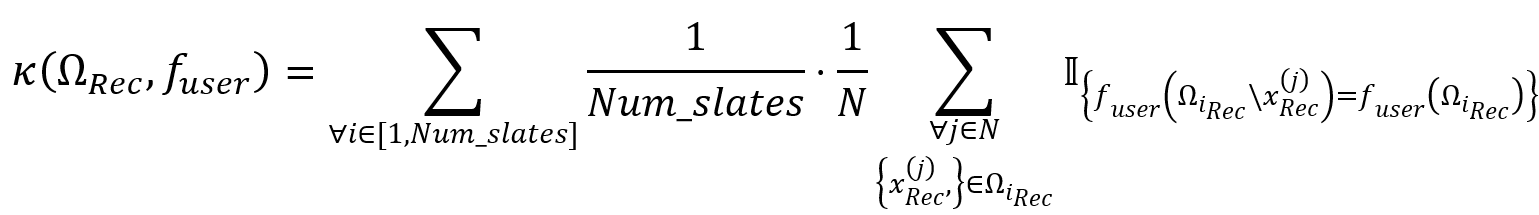

### Q2 - kappa implementation: 

🔴 implement the kappa score function using the features of recommended items per slate as generated in **Q1** by the **recommend_items_wraper** function.



🔵 **Answer Q2**

In [15]:
def kappa_eval_IIA(recommendations_features, num_rec_items, user_model, varnames = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4' ]):
    grouped_recommendations = recommendations_features.groupby('slate_id')
    
    IIA_counter = 0 
    c = 0 
    for _, slate_recom in grouped_recommendations:
        original_slate_recom = slate_recom[varnames]
        chosen_idx = user_model.choice(original_slate_recom.to_numpy())
        original_chosen_idx = original_slate_recom.index[chosen_idx]
        for idx in range(num_rec_items):
            if idx == chosen_idx:
                continue
            c+=1
            new_slate_recom = original_slate_recom.drop(index = original_slate_recom.index[idx])
            new_chosen_idx = user_model.choice(new_slate_recom.to_numpy())
            if (new_slate_recom.index[new_chosen_idx] == original_chosen_idx):
                IIA_counter+=1
    return IIA_counter/c


But, what if the user effects on the recommended items don't matter? meaning, what if our learned model learns such coefficients that transfer the recommended items to an embeding space where the chosen items far away from the rest of the recommended items. This may cause the context effects applied by the user to not have the ability to change the chosen item - creating a "delusion" of the IIA property. 

Given the generated dataset $\Omega$, obtain for **each** slate:
1. $\Omega_{Rec_{i}}$ - features of the recomended items of slate i.
2. $f_{user}$ - user model choice function.
3. $Scores(\Omega_{Rec_{i}})$ - choice scores of the rational user  of the recomended items per slate

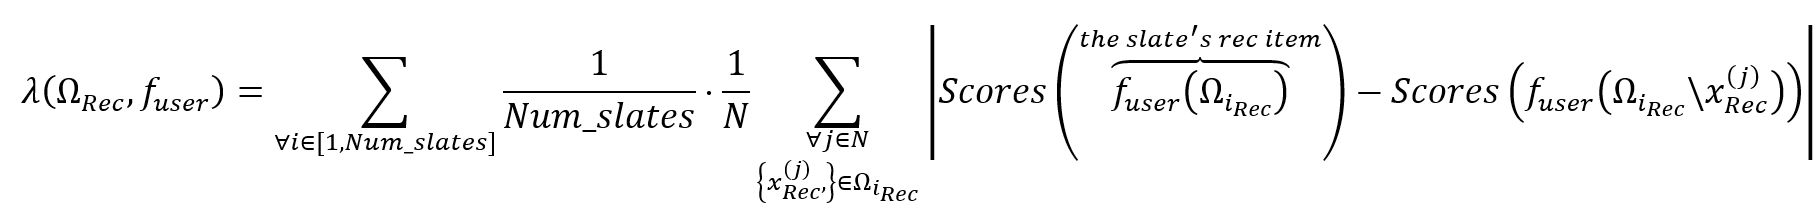

## Delusion Metric
### Q3 - Delusion Implementation: 

🔴 implement the delusion score function using the features of recommended items per slate of each model as generated in **Q1** by the **recommend_items_wraper** function.


🔵 **Answer Q3**

In [16]:
def delusion_score(recommendations_features, num_rec_items, user_model, rational_user, varnames = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4' ]):
    ## TODO: complete the code as described in Q3 ###
    dists_from_chosen_item = []
    slate_id_arr = np.unique(recommendations_features.slate_id)
    delusion_score_avg = 0
    for curr_slate_id in slate_id_arr:
        df_filter = recommendations_features[recommendations_features['slate_id'] == curr_slate_id]
        df_filter_arr = df_filter[varnames].to_numpy()
        old_chosen_item = user_model.choice(df_filter_arr)
        user_coice_coef_vanilla = rational_user.choice_coef(df_filter_arr)
        for item_idx in range(num_rec_items):
            if old_chosen_item == item_idx:
                continue
            dists_from_chosen_item.append(np.abs(user_coice_coef_vanilla[old_chosen_item] - user_coice_coef_vanilla[item_idx]))
        delusion_score_avg += np.abs(np.mean(np.array(dists_from_chosen_item)))
        dists_from_chosen_item = []
    delusion_score = delusion_score_avg / slate_id_arr.shape[0]

    ###########################################

    return delusion_score


 ## kappa and delusion calculation:

Run the following code to output the KAPPA and LAMBDA (delusion score) per learning model and user type:

In [17]:

def calc_kappa_delusion(env, recommendations_features_all_models, learning_models, num_items_to_recommend, varnames = [ 'x_0', 'x_1','x_2','x_3','x_4']):
    metrics_for_usr = {} 
    for user_model_name in env.user_models.keys():
        metrics_for_usr[user_model_name] = {}
        
        for model_name in list(learning_models.keys()):
            metrics_for_usr[user_model_name][model_name] = {}
            
            kappa_value_curr = kappa_eval_IIA(recommendations_features=recommendations_features_all_models[model_name][user_model_name],
                                          num_rec_items=num_items_to_recommend, user_model=env.user_models[user_model_name], varnames = varnames)

            lambda_delusion_score_curr_avg = delusion_score(recommendations_features=recommendations_features_all_models[model_name][user_model_name],
                                          num_rec_items=num_items_to_recommend, user_model=env.user_models[user_model_name], rational_user = RationalUserModel(np.arange(len(varnames))), varnames = varnames)
            
            metrics_for_usr[user_model_name][model_name]['kappa'] = kappa_value_curr
            metrics_for_usr[user_model_name][model_name]['delusion'] = lambda_delusion_score_curr_avg
            
    return metrics_for_usr

In [18]:
kappa_delusion_metrics  = calc_kappa_delusion(env, recommendations_features_all_models, learning_models, num_items_to_recommend)
display(kappa_delusion_metrics)

{'Attraction': {'logistic_reg': {'kappa': 0.9925,
   'delusion': 4.3737466483722365},
  'pairwise_ranker': {'kappa': 0.9925, 'delusion': 5.805619052637862},
  'svm_linear': {'kappa': 0.9925, 'delusion': 4.373842726504209},
  'svm_rbf': {'kappa': 0.955, 'delusion': 10.595517061099999}},
 'Compromise': {'logistic_reg': {'kappa': 0.7825,
   'delusion': 2.9107346065217503},
  'pairwise_ranker': {'kappa': 0.745, 'delusion': 3.9143828284681508},
  'svm_linear': {'kappa': 0.785, 'delusion': 2.9339643334559624},
  'svm_rbf': {'kappa': 0.77, 'delusion': 7.50063345937111}},
 'Similarity': {'logistic_reg': {'kappa': 0.7525,
   'delusion': 3.104135830537972},
  'pairwise_ranker': {'kappa': 0.735, 'delusion': 4.08071296946077},
  'svm_linear': {'kappa': 0.755, 'delusion': 3.1718858643059535},
  'svm_rbf': {'kappa': 0.7625, 'delusion': 7.290393674115672}},
 'Rational': {'logistic_reg': {'kappa': 1.0, 'delusion': 4.477042349889412},
  'pairwise_ranker': {'kappa': 1.0, 'delusion': 5.890660167026336},


## Q4 - kappa - delusion plots: 

🔴  Produce the following plots **and explain them**:
1. Two bar plots, one showing the kappa and the second shows the delusion, for each user type. Each user type should have a bar for each model. Include a legend that shows the name of each model represented by a different color in the plot.  
    **Analyse the plot**

2. Eight bar plots. for each learning model (4 in total), one bar plot evaluating the Kappa score (y-axis) and the other one evaluating the Delusion score (y-axis) as a function of the user models (x-axis). Each bar should indicate the number of items recommended.  
   **Analyse the plot**

**Evaluate on 5,10 and 15 recommended items per slate!**

🔵 **Answer Q4.1 - producing the plot**

In [19]:
import matplotlib.pyplot as plt
import numpy as np


def bar_plot_q4_1(kappa_delusion_metrics): 
   # Extract list of models from the dictionary
    models = []
    for group, group_dict in kappa_delusion_metrics.items():
        for model in group_dict.keys():
            if model not in models:
                models.append(model)

    # Create a dictionary to store the data for each metric
    kappa_data = {}
    delusion_data = {}

    # Populate the dictionary with the data for each metric
    for group, group_data in kappa_delusion_metrics.items():
        kappa_data[group] = [group_data[model]['kappa'] for model in models]
        delusion_data[group] = [group_data[model]['delusion'] for model in models]

    # Set the width of each bar
    bar_width = 0.2

    # Set the x-axis labels
    x_labels = list(kappa_delusion_metrics.keys())

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Create a bar plot for kappa data
    for i, model in enumerate(models):
        ax1.bar(np.arange(len(kappa_delusion_metrics)) + i * bar_width, [kappa_data[group][i] for group in kappa_delusion_metrics], width=bar_width, label=model)

    # Set the x-axis labels and title for the kappa plot
    ax1.set_xticks(np.arange(len(kappa_delusion_metrics)) + bar_width * (len(models) - 1) / 2)
    ax1.set_xticklabels(x_labels)
    ax1.set_xlabel('User Model')
    ax1.set_ylabel('Kappa')
    ax1.set_title('Kappa by User Type and Model')

    # Create a legend for the models
    ax1.legend()

    # Create a bar plot for delusion data
    for i, model in enumerate(models):
        ax2.bar(np.arange(len(kappa_delusion_metrics)) + i * bar_width, [delusion_data[group][i] for group in kappa_delusion_metrics], width=bar_width, label=model)

    # Set the x-axis labels and title for the delusion plot
    ax2.set_xticks(np.arange(len(kappa_delusion_metrics)) + bar_width * (len(models) - 1) / 2)
    ax2.set_xticklabels(x_labels)
    ax2.set_xlabel('User Model')
    ax2.set_ylabel('Delusion')
    ax2.set_title('Delusion by User Type and Model')

    # Create a legend for the models
    ax2.legend()

    # Show the plots
    plt.show()


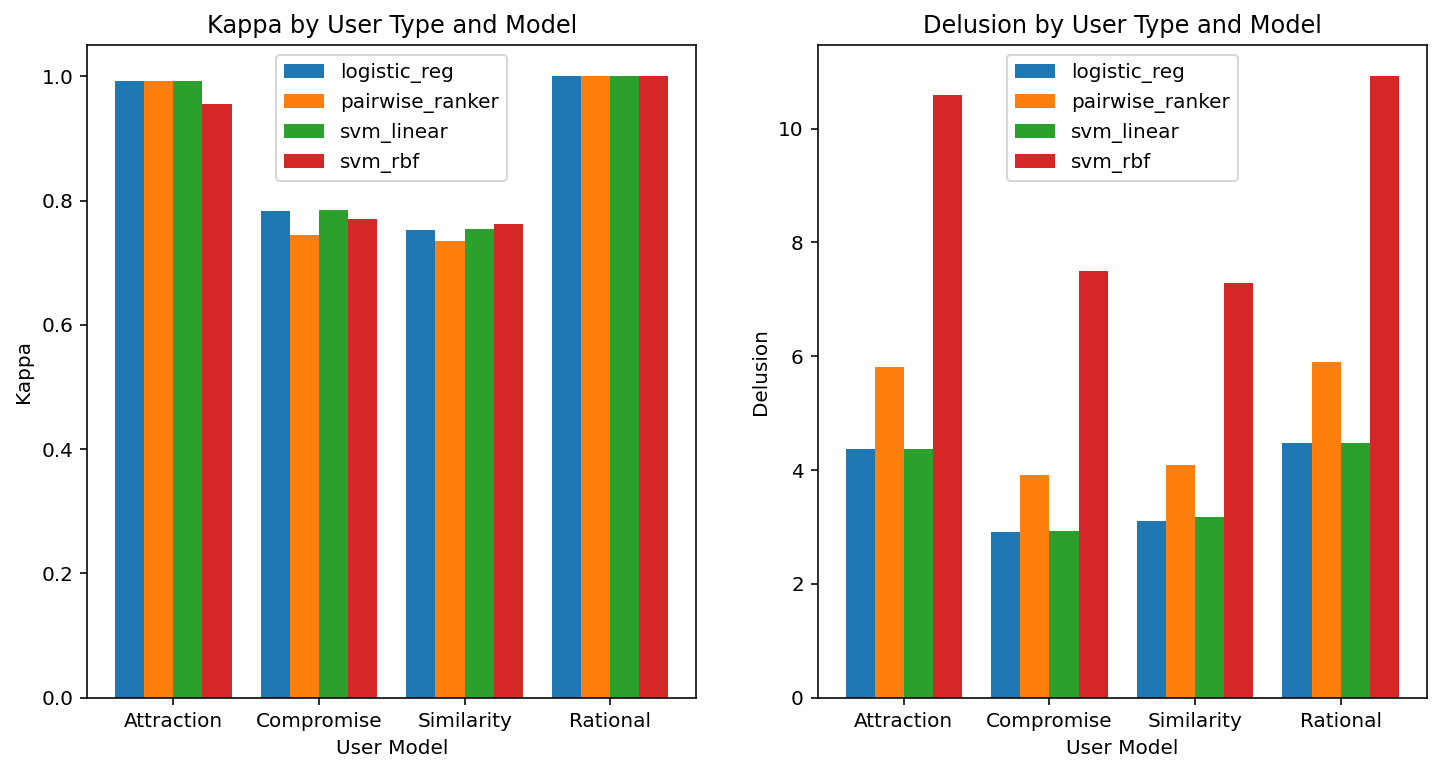

In [20]:
bar_plot_q4_1(kappa_delusion_metrics)

🔵 **Answer Q4.1 - explaining the plot**

1. **Kappa**  
**--- effect of user model ---**

  * For Rational user the kappa is always 1 regardless of the learning model used for recommendation. This observation is expected because the Rational user has a fixed set of weights that determine the score given to each item, such that given any set of recommended items(**produced by any learning model**), removing any non-relevant item from the recommended set does not change the item with the maximum score. 
  * In contrast, behavioral user models who activate a behavioral bias, we notice a drop in the kappa value. We know that the bias applied by attraction is milder than the bias applied by compormise and similarity, which explains why the attraction kappa is larger than Similarity / Compromise (larger bias means larger effect on the embedding space of the recommended items, which leads to higher chance of the chosen item to vary).  
    
    
**--- effect of learning model ---**  
  * For all user models, we can see that the svm_linear and logistic regression models give identical kappa values. These models are similar since they both learn a linear separator on the data. The major difference is that svm optimizes the hinge loss from the separator while the logistic regression model optimized the CE loss over the probabilites - these models could end up learning a very similar linear separators. In recommendation time the models choose the highest scoring items, svm gives linear scores while logistic applies sigmoid over the linear scores, but since sigmoid doesnt change the order of items score, it could happen that they both recommend the very same items !  
  * For the Compromise and Similarity users, the (non-IIA model) pairwise ranker gives the smallest kappa value - i.e **recommended sets produced by the pairwise ranker exibit the lowest IIA on behavioral users** .

-
  
-
  
2. **Delusion**  
**--- effect of user model ---**
  * 1. As expected, users who obtain higher kappa-value (attraction, rational) have a higher delusion score compared to those with lower kappa value (compromise, similarity) - i.e. the chosen item is given a score that is is much larger than the non-chosen items - therefore making it harder for items other than the chosen item to be selected when the chosen item is removed.

  
**--- effect of learning model ---**  
  * the svm_linear and logistic regression models give identical kappa values, as explained above for kappa, these models are very similar.
  * Svm_rbf obtains the largest delusion values across all user types. Svm_rbf learns non-linear seperators, making the delusion scores higher (better seperation of points, making the items' embedded space sparser).
  * Paiwise ranker has higher delusion than the logistic and svm.

🔵 **Answer Q4.2  - producing the plot**

In [21]:
def bar_plot_q4_2(learning_models, env, num_items_to_recommend_options, varnames = [ 'x_0', 'x_1','x_2','x_3','x_4'], varnames_ = [ 'x_0', 'x_1','x_2','x_3','x_4'] ):
    fig, axes = plt.subplots(nrows=len(learning_models), ncols=2, figsize=(15, 7*len(learning_models)))
    x = list(env.user_models.keys())
    width = 0.2
    
    
    trained_models = train_all_models_for_users(learning_models, env, varnames = varnames)
    for j, n in enumerate(num_items_to_recommend_options):
        # print(f"------ recommending {n} items")
        recommendations_features_all_models = generate_recommendations(n, trained_models, env, varnames = varnames_)
        for i, model_name in enumerate(list(learning_models.keys())):
            kappa_y = []
            delusion_y = []
            user_model_names = []
            for k, user_model_name in enumerate(env.user_models.keys()):
                kappa_value_curr = kappa_eval_IIA(recommendations_features_all_models[model_name][user_model_name], num_rec_items=n, user_model=env.user_models[user_model_name], varnames = varnames_)
                kappa_y.append(kappa_value_curr)

                lambda_delusion_score_curr_avg = delusion_score(recommendations_features_all_models[model_name][user_model_name], num_rec_items=n, user_model=env.user_models[user_model_name], rational_user=RationalUserModel(np.arange(len(varnames_))), varnames = varnames_)
                delusion_y.append(lambda_delusion_score_curr_avg)

                user_model_names.append(user_model_name)
            axes[i][0].bar(np.arange(len(user_model_names)) + (j * width), kappa_y, width=width, label=f"{n} recommended items")
            axes[i][1].bar((np.arange(len(user_model_names))) + (j * width), delusion_y, width=width, label=f"{n} recommended items")
    
    
    for i, model_name in enumerate(list(learning_models.keys())):
        axes[i][0].set_title(model_name)
        axes[i][0].set_ylabel("Kappa Score")
        axes[i][0].set_xticks(np.arange(len(env.user_models)) + width*(len(num_items_to_recommend_options)-1)/2)
        axes[i][0].set_xticklabels(env.user_models.keys())
        axes[i][0].legend()
        axes[i][1].set_title(model_name)
        axes[i][1].set_ylabel("Delusion Score")
        axes[i][1].set_xticks(np.arange(len(env.user_models)) + width*(len(num_items_to_recommend_options)-1)/2)
        axes[i][1].set_xticklabels(env.user_models.keys())
        axes[i][1].legend()

    plt.show()


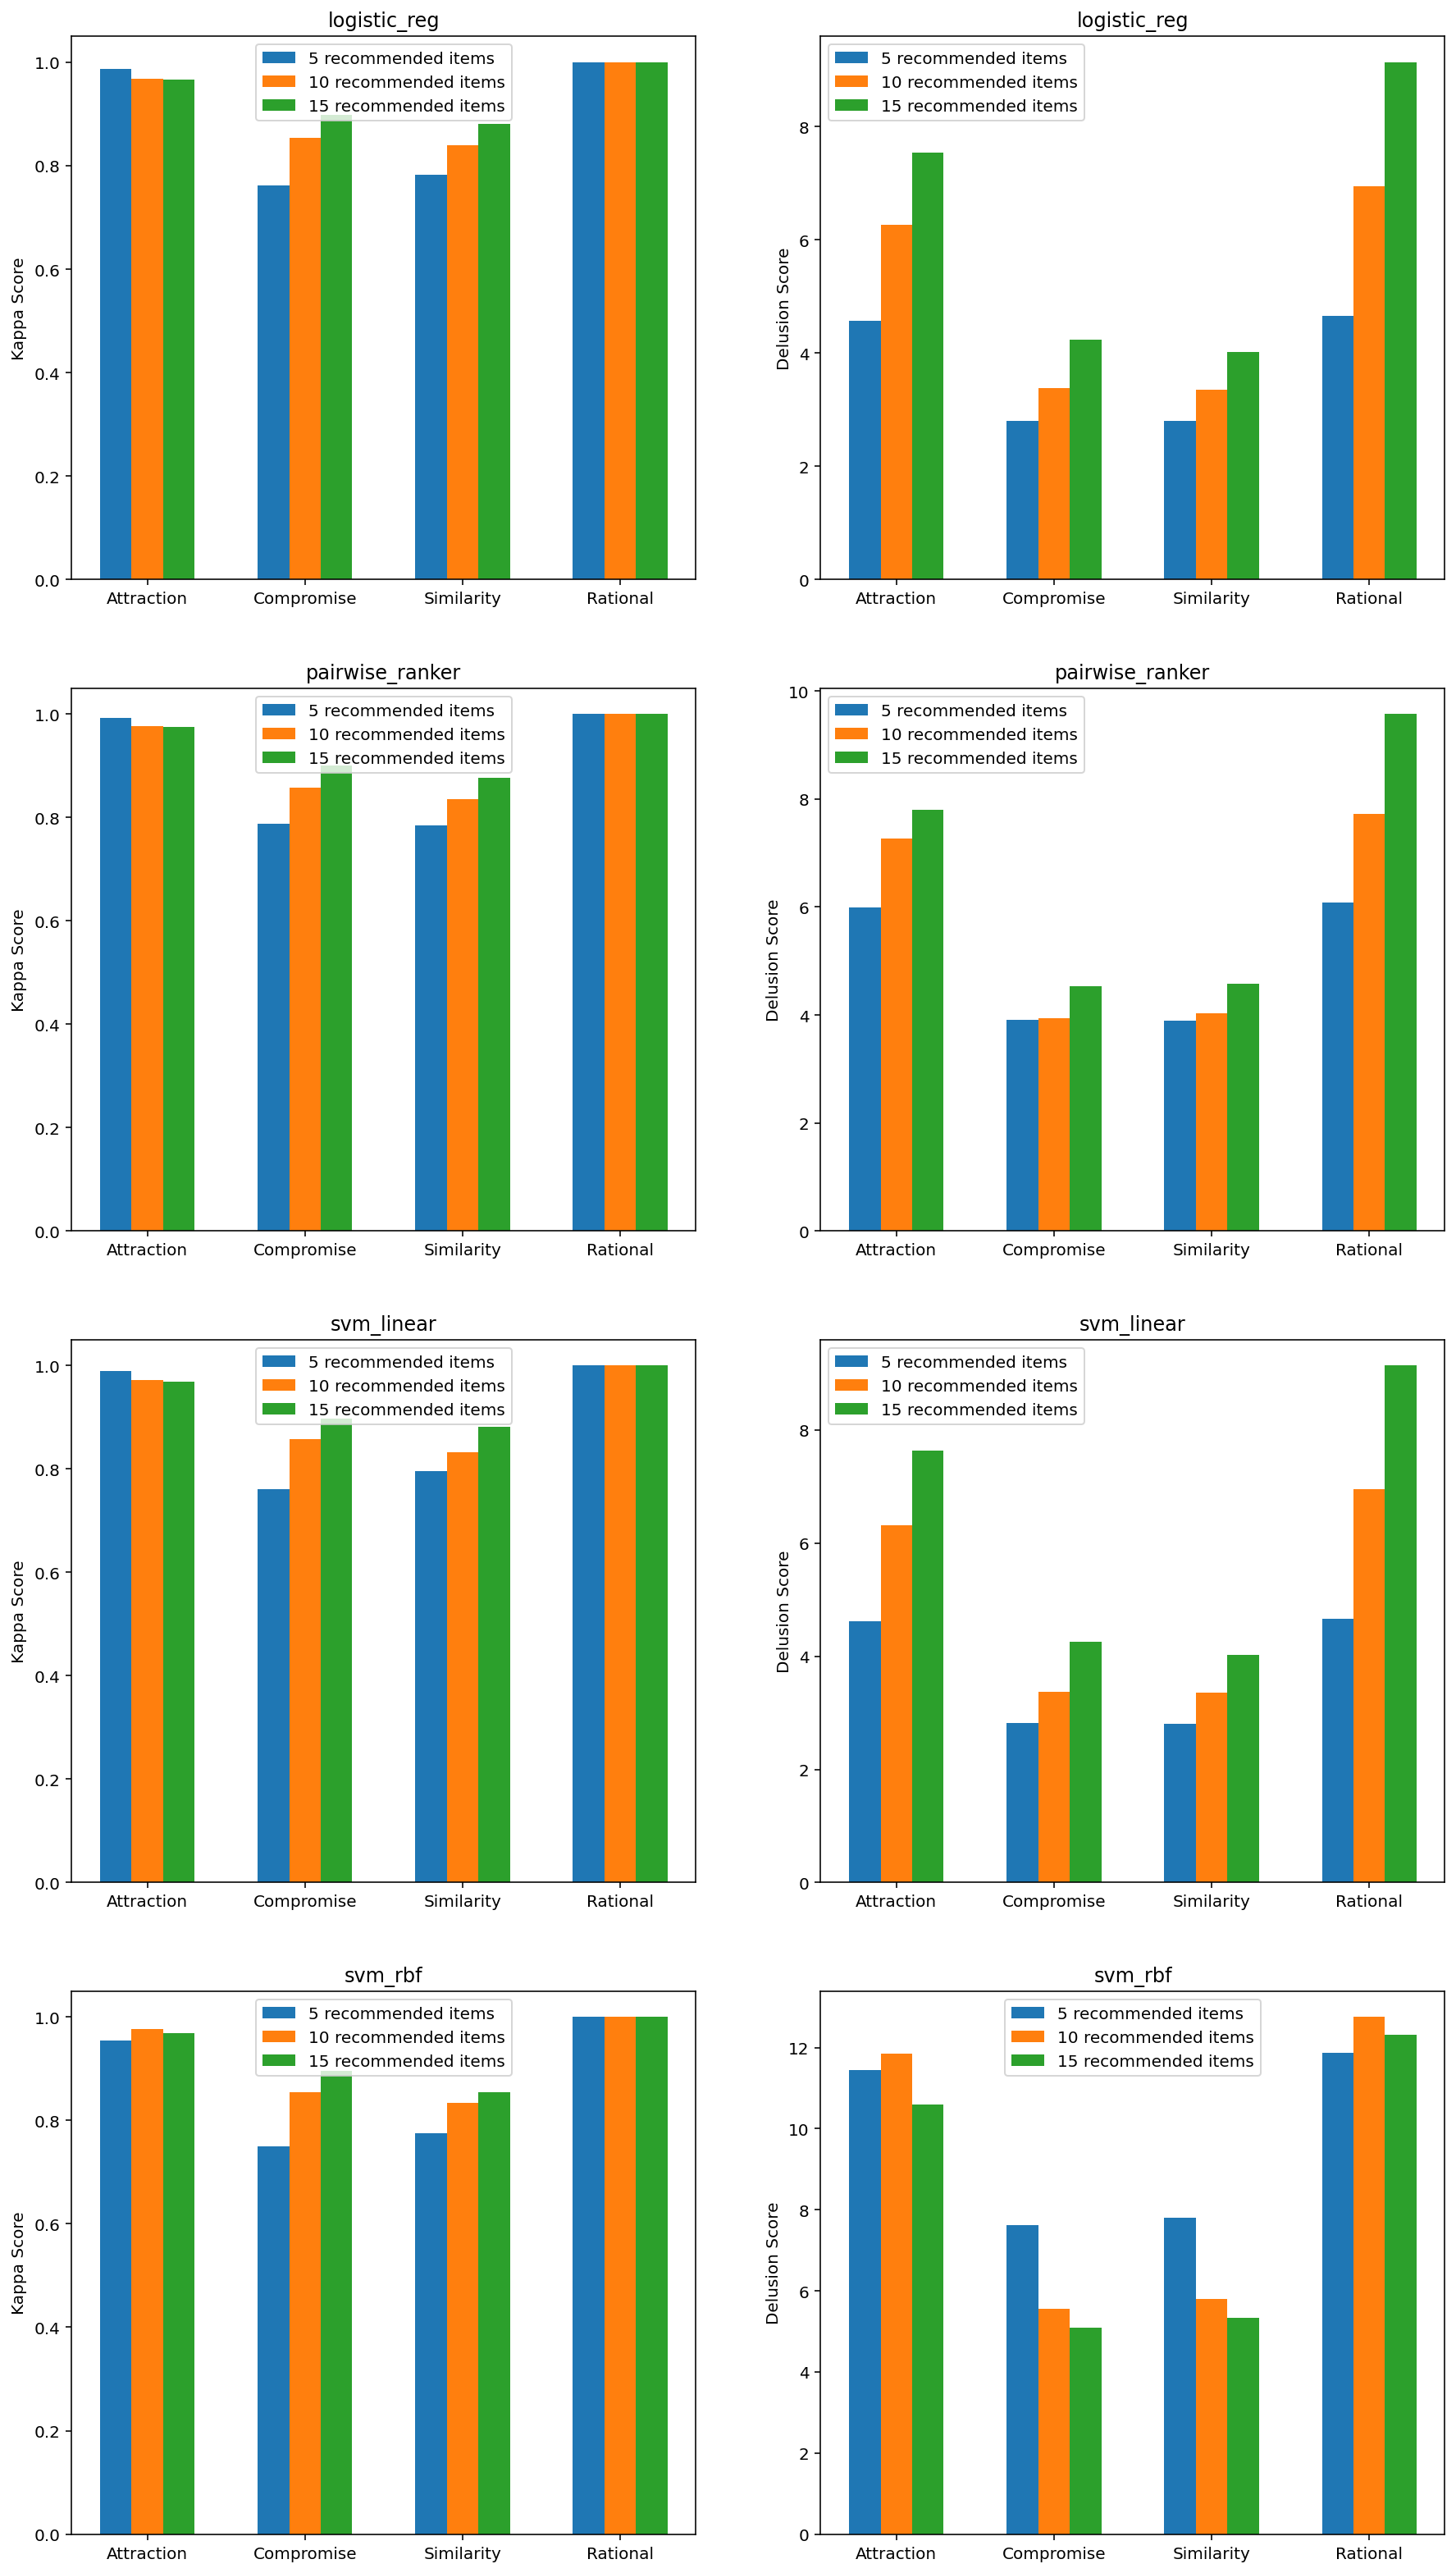

In [22]:

learning_models = {'logistic_reg': LogisticRegression(), 'pairwise_ranker': MyRanker(),
            'svm_linear': OneVsRestClassifier(SVC(kernel='linear', probability=True)), 'svm_rbf': OneVsRestClassifier(SVC(kernel='rbf', gamma=0.5, C=0.5, probability=True))}

num_items_to_recommend_options = [5, 10, 15]
bar_plot_q4_2(learning_models, env, num_items_to_recommend_options)

🔵 **Answer Q4.2 - explaining the plot**

1. Kappa -  
    For Compormise and Similarity (stronger bias compared to the attraction bias) we see that the more items we recommend, the bigger the kappa value is, for all learning models (larger kappa -> "more IIA"). This is because there's a larger ratio of items we remove who are chosen rarely and when removed, the chosen item stays the same - "contirbuting" to the IIA ratio of the slate. 
    For Rational user we see a a perfect IIA behaviour with kappa = 1 regardless of number of recommended items or learning models, because again as exaplined before, this user is completely set independent. Under the attraction case, because its bias is weaker and more similar to the Rational user, we see that the number of recommended items almost doesn't effect its kappa value (~ kappa = 1) and this setup demonstrates an almost perfect IIA behavior. 

2. Delusion - 
    In all learning models except svm_rbf, we see that the delusion increases with the number of recommended items. When the recommended set gets larger, it makes sense that more items with low model score will be introduced, which increases the average distance of non relevant items scores from the chosen one. 
    We can see once again, that for all learning models and behavioral users, the higher the kappa is for a certain number of recommended items, the higher is the delusion score. 

### Statistics of recommendations similarity accross models

Now, we'd like to further compare the recommendations and chosen items of IIA and non-IIA learning models on our experiment setup.
The pairwise ranker would be compared against each of the IIA models (logistic_reg, svm_linear, svm_rbf).

### Q5:recommendations similarity

🔴 Examine similarity of recommendations between the models to justify the similar behavior we obsereved in previous sections by implementing the "compare_2_models" function.

compare_2_models function input:
- recommendations_features_model1 = features of recommended items of all slates of model1 under the current behavioral user
- recommendations_features_model2 = features of recommended items of all slates of model2 under the current behavioral user
- num_rec_items = the number of recommended items per slate
- user_model - the current behavioral user applied

compare_2_models function output:

- prob. to receive identical chosen item out of the recommended items per slate of each model.
- prob. to receive identical chosen item out of the recommended items per slate of each model **and** the same chosen item when removing one item out of the recommended set of items of the slate.

🔵 **Answer Q5:** 

In [54]:
def compare_2_models(recommendations_features_model1, recommendations_features_model2,
                            num_rec_items, user_model):
  
  ### TODO: complete the code as described in Q6 ###
  count_similar_old_chosen_item = 0
  ratio_similar_new_and_old_chosen_item = 0
  
  slate_id_arr = np.unique(recommendations_features_model1.slate_id)

  for curr_slate_id in slate_id_arr:
      is_same_old_chosen_item = False
      df_filter_model1 = recommendations_features_model1[recommendations_features_model1['slate_id'] == curr_slate_id]
      df_filter_model2 = recommendations_features_model2[recommendations_features_model2['slate_id'] == curr_slate_id]
      df_filter_arr_model1 = df_filter_model1.drop(columns=['slate_id']).to_numpy(copy=True)
      df_filter_arr_model2 = df_filter_model2.drop(columns=['slate_id']).to_numpy(copy=True)
      old_chosen_item_model1 = user_model.choice(df_filter_arr_model1)
      old_chosen_item_model2 = user_model.choice(df_filter_arr_model2)
      
      if old_chosen_item_model1 == old_chosen_item_model2:
          count_similar_old_chosen_item += 1
          for item_idx in range(num_rec_items):
            if old_chosen_item_model1 == item_idx:
                continue
            df_filter_new_model1 = df_filter_model1.drop(index = [df_filter_model1.index[item_idx]], columns = ['slate_id']).to_numpy(copy=True)
            df_filter_new_model2 = df_filter_model2.drop(index = [df_filter_model2.index[item_idx]], columns = ['slate_id']).to_numpy(copy=True)
            new_chosen_item_model1 = user_model.choice(df_filter_new_model1)
            new_chosen_item_model2 = user_model.choice(df_filter_new_model2)
            if new_chosen_item_model1 == new_chosen_item_model2:
              ratio_similar_new_and_old_chosen_item += 1
          
  ###########################################

  return ratio_similar_new_and_old_chosen_item / ((num_rec_items-1)*len(slate_id_arr)), count_similar_old_chosen_item / len(slate_id_arr)


### Q6 - more plots: 

🔴 Produce the following scatter plots:

1. For each behavioral user: prob. that the **old chosen items** are the same between the pairwise ranker and the IIA learning model (Y-axis) as a function of **each** IIA learning model compared to the pairwise-ranker (X-axis) - Total of 4 plots

2. For each behavioral user: prob. that the **new and old chosen items** are the same between the pairwise ranker and the IIA learning model (Y-axis) as a function of **each** IIA learning model compared to the pairwise-ranker (X-axis) - Total of 4 plots


**Evaluate on 5,10 and 15 recommended items per slate!**

In [76]:
def scatter_q6(learning_models, env, num_items_to_recommend_options, varnames = [ 'x_0', 'x_1','x_2','x_3','x_4'], varnames_ = [ 'x_0', 'x_1','x_2','x_3','x_4'] ):
    fig, axes = plt.subplots(nrows=len(learning_models), ncols=2, figsize=(15, 7*len(learning_models)))
    width = 0.2
    
    ### TODO: complete the code as described in Q6 ###
    x = ['logistic_reg', 'svm_linear', 'svm_rbf']
    y = [[] , []]
    trained_models = train_all_models_for_users(learning_models, env, varnames = varnames)
    for j, n in enumerate(num_items_to_recommend_options):
        # print(f"------ recommending {n} items")
        recommendations_features_all_models = generate_recommendations(n, trained_models, env, varnames = varnames_)
        for i, user_model_name in enumerate(env.user_models.keys()):
          for model_name in x:
            ratio_similar_new_and_old_chosen_item, ratio_similar_old_chosen_item = compare_2_models(recommendations_features_model1 = recommendations_features_all_models[model_name][user_model_name],
                                                                                                                recommendations_features_model2 = recommendations_features_all_models['pairwise_ranker'][user_model_name],
                                                                                                                num_rec_items = n, 
                                                                                                                user_model=env.user_models[user_model_name])
            y[0].append(ratio_similar_old_chosen_item)
            y[1].append(ratio_similar_new_and_old_chosen_item)

          axes[i][0].bar((np.arange(len(x))) + (j * width), y[0], width=width, label=f"{n} recommended items")
          axes[i][1].bar((np.arange(len(x))) + (j * width), y[1], width=width, label=f"{n} recommended items")
          y = [[] , []]

    
    for i, user_name in enumerate(list(env.user_models.keys())):
        axes[i][0].set_title(user_name, fontdict={'size':18})
        axes[i][0].set_ylabel("ratio_similar_old_chosen_item", fontdict={'size':14})
        axes[i][0].set_xticks(np.arange(len(x)) + width*(len(num_items_to_recommend_options)-1)/2)
        axes[i][0].set_xticklabels(x, fontdict={'size':12})
        axes[i][0].legend()
        axes[i][1].set_title(user_name, fontdict={'size':18})
        axes[i][1].set_ylabel("ratio_similar_new_and_old_chosen_item", fontdict={'size':14})
        axes[i][1].set_xticks(np.arange(len(x)) + width*(len(num_items_to_recommend_options)-1)/2)
        axes[i][1].set_xticklabels(x, fontdict={'size':12})
        axes[i][1].legend()
    ###########################################
    plt.show()


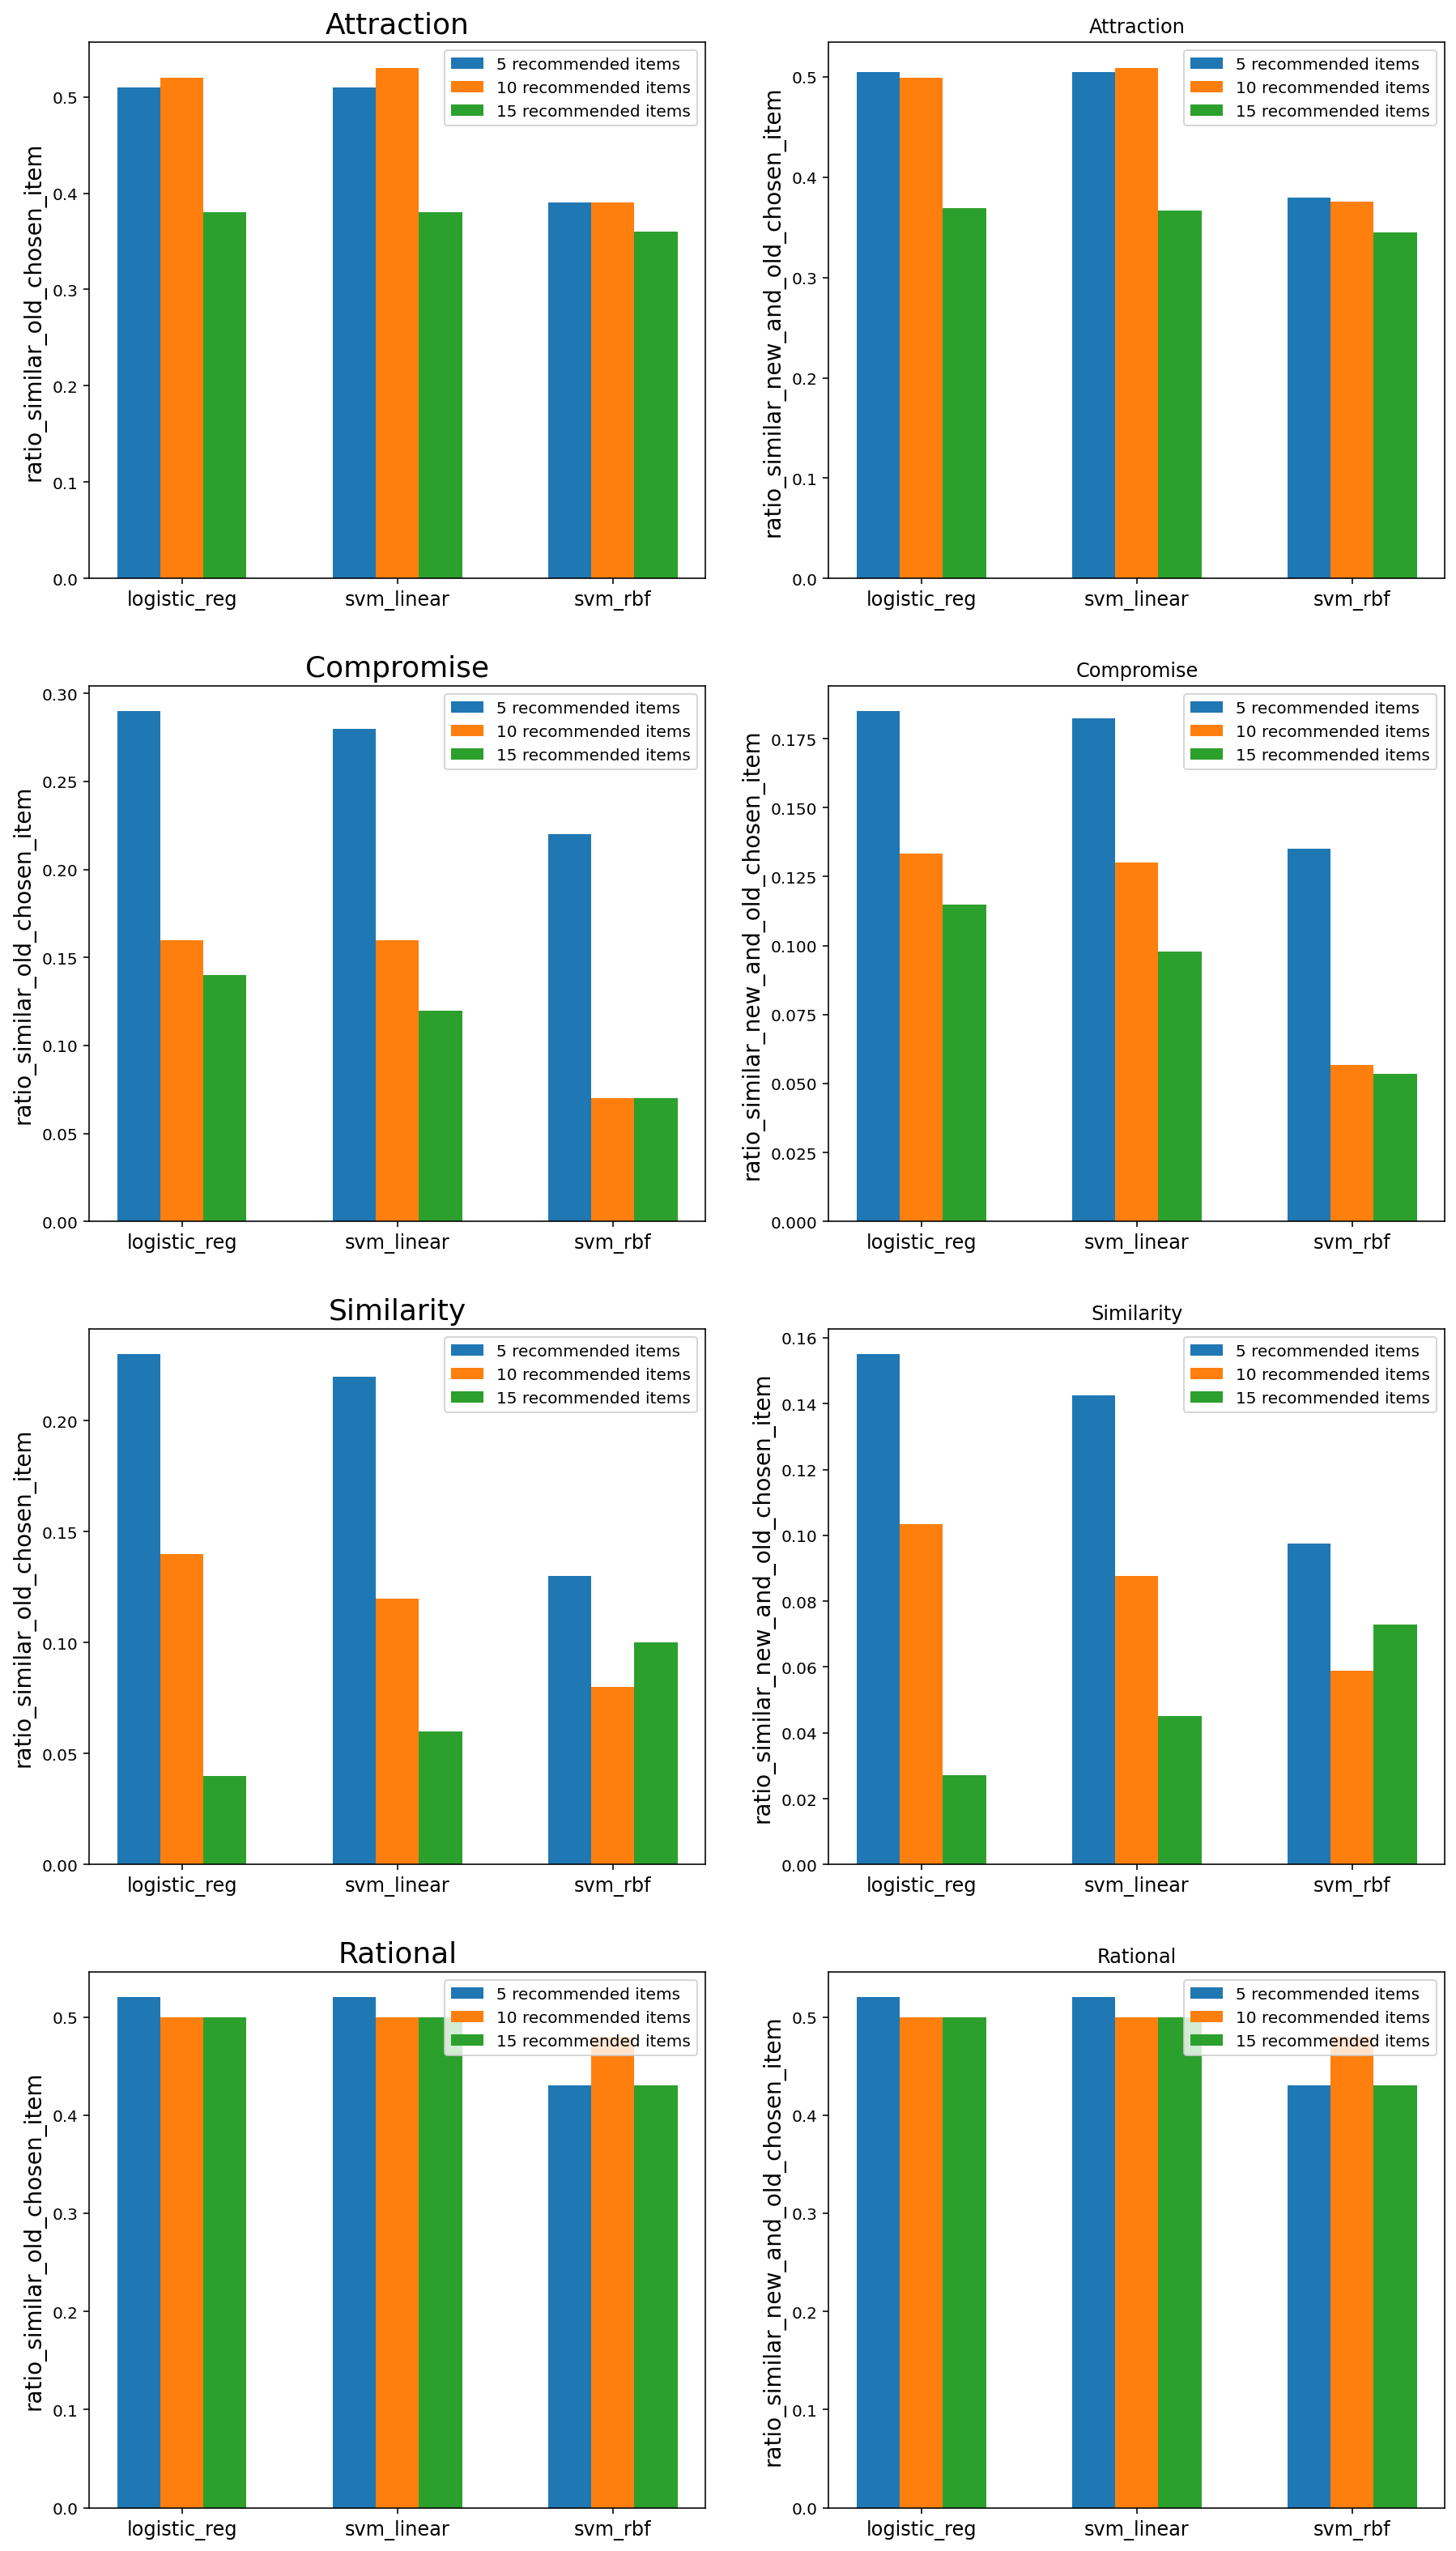

In [75]:
learning_models = {'logistic_reg': LogisticRegression(), 'pairwise_ranker': MyRanker(),
            'svm_linear': OneVsRestClassifier(SVC(kernel='linear', probability=True)), 'svm_rbf': OneVsRestClassifier(SVC(kernel='rbf', gamma=0.5, C=0.5, probability=True))}

num_items_to_recommend_options = [5, 10 , 15]
scatter_q6(learning_models, env, num_items_to_recommend_options)

### Q7:

🔴 Explain the plots. 
- In your answer refer to the diferences in: User model, IIA Learning model, number of recommended items per slate. 

- How are these results help to explain / relate to the kappa values of the learning models per behavioral user you received in Q5?

🔵 **Answer Q7**:

Important observations: 
- **The logistic regression model (MNL) resembles the pairwise ranker the most** in its recommendations. This claim is supported by the high ratio of chosen item before and after a removal of one item off the recommendations on the Users.
- As seen for the kappa values, **compromise & similaritiy , rational & attraction plots show the same trends** in the above plots and are almost identical.
- Although having almost identical kappa values per user and number of recommended items, the svm_linear and logistic_reg are shown to recommend different items to the user because logistic_reg recommends items very much like the pairwise-ranker (observation 1) while svm_linear have lower ratios of similar items chosen compared to the pairwise-ranker. **Meaning, having almost identical kappa values doesn't imply on almost identical recommended chosen item.**




## Summary and Discussion of Part 1: 

### Q8:

After producing and analyzing the relevant results over the experiment setup, answer the research question:

🔴 Do users make more IIA choices when using an IIA model compared to non-IIA model? If so, are user choices really set independent or is it a delusion caused by the IIA model?

🔴 Do you think your answer might change over a diferent experiment setup? why?

🔵 **Answer Q8:** 

- Do users make more IIA choices when using an IIA model compared to non-IIA model? - NO!

  From the plot produced in Q4.1, we see that paiwise ranker does obtain a slightly smaller kappa value for some of the behavioral users(Compromise and Similarity )

- Are user choices really set independent or is it a delusion caused by the IIA model? - Yes! the delusion factor exists

  From the plots produced in Q4, we can also observe that the higher the kappa value the higher the delusion score as well. Meaning that the delusion is also a cause for the IIA property of the users. This was observed across all learning models.

- Do you think your answer might change over a diferent experiment setup? why? - Yes! it might change mainly due to the dataset generation process

  **Remember, our experiment's dataset generator is random! soo the pairwise-ranker can't really find meaningful connection between the items in a slate. Maybe, we would've seen different non-IIA model recommendations on real-world data with inner connections between rows (=items)**



# Part 2: MNL (IIA model) vs. the Mixed-MNL (non-IIA model) on **real-world data**

In the first part of the assignment, we worked with synthetic data and evaluated the IIA property of the choices of different bias users and different recommendation learning models (IIA and non-IIA).
Now, it's time to examine our hypothesis on real-world data!





## Swiss-Metro Data preparation

The data we chose to work with is "SwissMetro". 
In SwissMetro data, a respondent is presented with 9 different choice samples, each choice sample consists of 3 transporation options: Car, Train and Swiss-metro. Each such alternative has a number of unique features describing it, and the respondent chooses one alternatinve from each choice sample of 3 alternatives. 

for more information on the meaning of each feature in the data, please refer to the following paper; http://www.sze.hu/~prile/Doktori%20iskola%202018/adatok%20leiras.pdf


### SwissMetro generator 

In [33]:
!pip install xlogit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import pandas as pd
import numpy as np

from xlogit.utils import wide_to_long

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

class SwissMetro():
    def __init__(self, varnames = [ 'INCOME', 'HE', 'CO', 'TT']):
        beta_h = np.arange(len(varnames))
        self.user_models = {
            'Real' : RationalUserModel(beta_h), 
            'Compromise' : CompromiseUserModel(beta_h, 100),
            'Similarity' : SimilarityUserModel(beta_h, 100),
            'Attraction' : AttractionUserModel(beta_h,100),
            }
        self.varnames = varnames 
        self._prepare_data()
        
    def _train_test_split(self, df): # used to split the swissmetro data to train - test
        
        ######### Q2 : TODO: implement train-test split on the slate level #########
        gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=123)
        split_indices = list(gss.split(df, groups=df['slate_id']))

        train_split_indices, test_split_indices  = split_indices[0]

        train_df, test_df = df.iloc[train_split_indices], df.iloc[test_split_indices]
        self.train_df = train_df
        self.test_df = test_df
        ############################################################################  
        return train_df, test_df
    
    
    def _user_model_choices(self, df):
        '''
            returns a dataframe of 4 column, each representing the choices of a specific user model given the swissmetro data
        '''
        ######### Q1.1: TODO: implement user choices of the 4 user models ['Rational', 'Attraction', 'Compromise', 'Similarity'] on top of the swissmetro data##########
    
        alts = ['TRAIN', 'SM', 'CAR']
        grouped_df = df.groupby('sample_id')
        
        choices = {user_name:[] for user_name in self.user_models.keys()}
        for id, group in grouped_df:
            for user_name, user_model in self.user_models.items():
                if user_name == "Real":
                    choices[user_name] = df['CHOICE']
                    continue
                user_choice_idx = user_model.choice(group[self.varnames].values)
                user_choices = [alts[user_choice_idx]]*3 
                choices[user_name].extend(user_choices)
        choices_df = pd.DataFrame(choices)
        df = pd.concat([df, choices_df], axis =1)
        return df
    
        ###################

    def _prepare_data(self):
        
        # df_wide = pd.read_table("data/swissmetro.dat", sep='\t')
        df_wide = pd.read_table("http://transp-or.epfl.ch/data/swissmetro.dat", sep='\t')
        
        # Keep only observations for commute and business purposes that contain known choices
        df_wide = df_wide[(df_wide['PURPOSE'].isin([1, 3]) & (df_wide['CHOICE'] != 0))]

        df_wide['sample_id'] = np.arange(len(df_wide))  # Add unique identifier
        df_wide['CHOICE'] = df_wide['CHOICE'].map({1: 'TRAIN', 2:'SM', 3: 'CAR'})
        df_wide.rename(columns = {'ID': 'person_id'}, inplace = True)
        df = wide_to_long(df_wide, id_col='sample_id', alt_name='alt', sep='_',
            alt_list=['TRAIN', 'SM', 'CAR'], empty_val=0,
            varying=['TT', 'CO', 'HE', 'AV', 'SEATS'], alt_is_prefix=True)
        df['INCOME'] = np.clip(np.random.normal(loc=5, scale=1, size=len(df)), a_min=1, a_max=None)
        
        self.orig_long_data = df.reindex(columns = ['person_id', 'sample_id', 'alt'] +  self.varnames + ['CHOICE']).copy()
      
        
        ########### Q1.2: TODO rename person_id column to slate_id ###########
        
        df.rename(columns = {'person_id': 'slate_id'}, inplace = True)
        ######################################################################
        ########### Q1.3: TODO: add normal distribution column R #############
        # df['R'] = np.random.normal(0, 1, len(df))
        
        ######################################################################
        
        df['ASC_TRAIN'] = np.ones(len(df))*(df['alt'] == 'TRAIN')
        df['ASC_CAR'] = np.ones(len(df))*(df['alt'] == 'CAR')
        df['ASC_SM'] = np.ones(len(df))*(df['alt'] == 'SM')
        df['TT'], df['CO'], df['HE'], df['WHO'] = df['TT']/100, df['CO']/100, df['HE']/100, df['WHO']/3  # Scale variables
        
        # annual_pass = (df['GA'] == 1) & (df['alt'].isin(['TRAIN', 'SM']))
        # df.loc[annual_pass, 'CO'] = 0  # Cost zero for pass holders]
        # add a new column with random normal values
        df = self._user_model_choices(df)
        self.modf_long_data = df.reindex(columns = ['slate_id', 'sample_id', 'alt'] +  self.varnames + list(self.user_models.keys())).copy()

        return self._train_test_split(df)

    def generate_datasets(self, **kws):
        X_train = self.train_df[['slate_id', 'sample_id',  'AV', 'alt'] + self.varnames]
        X_test = self.test_df[['slate_id', 'sample_id', 'AV', 'alt'] + self.varnames]
        y_train = self.train_df[['slate_id'] + list(self.user_models.keys())]
        y_test = self.test_df[['slate_id'] + list(self.user_models.keys())]
        return X_train, X_test, y_train, y_test

 

Now, let's inspect the data and get a better understanding of the relevant columns:

In [35]:
varnames = ['INCOME', 'HE', 'CO', 'TT' ]
sm_env = SwissMetro(varnames)

display(
    sm_env.orig_long_data.head(27)
)

,person_id,sample_id,alt,INCOME,HE,CO,TT,CHOICE
0,1,0,TRAIN,7.555122,120,48,112,SM
1,1,0,SM,4.954238,20,52,63,SM
2,1,0,CAR,5.593832,0,65,117,SM
3,1,1,TRAIN,6.360597,30,48,103,SM
4,1,1,SM,4.210557,10,49,60,SM
5,1,1,CAR,4.482585,0,84,117,SM
6,1,2,TRAIN,5.005392,60,48,130,SM
7,1,2,SM,4.357473,30,58,67,SM
8,1,2,CAR,5.162925,0,52,117,SM
9,1,3,TRAIN,4.543664,30,40,103,SM


**person_id** : unique identifier of the responding person  
**sample_id** : unique identifier of the sample conisisting 3 alternatives presented to the person  
**alt** : type of the alternative - car, train or swissmetro  
**INCOME** : Traveler's income per month [thousand CHF].  
**HE** : headway of the alternative  - If there are two Swissmetros per hour, the value of its HE is 30.  
**CO** : Cost of the alternative (the transportation method)  
**TT** : travel time of the alternative (the transportation method)  
**CHOICE** : Choice indicator for the given sample_id, made by the real world users. Note that each set of 3 alterantive of the same sample_id have the same choice indicator. 

### Q1 - User Choice Modeling and Slate split

1. 🔴 **Implement the method "_user_model_choices"** in the class "SwissMetro" shown above :
    - Replace the original users choice (column "CHOICE") with  the name "REAL" indicatig that the choices are made by the real world user
    - Add 3 more choice columns, each indicating the choices of one of 3 behavioral users : Compromise, Similarity and Attraction.


In Addition, now we will consider the "person_id" column as a slate_id - This way we will consider the choices as if they were made by one instance of a user (each user type individually), and instead of the original choices split by person_id, we will cosider the choices as if they were split for slates on the same user instance.

2. 🔴 **rename the user_id column to "slate_id"**

modified swissmetro data will be the following : 

In [36]:
display(
    sm_env.modf_long_data.head(27)
)

,slate_id,sample_id,alt,INCOME,HE,CO,TT,Real,Compromise,Similarity,Attraction
0,1,0,TRAIN,7.555122,1.2,0.48,1.12,SM,CAR,CAR,TRAIN
1,1,0,SM,4.954238,0.2,0.52,0.63,SM,CAR,CAR,TRAIN
2,1,0,CAR,5.593832,0.0,0.65,1.17,SM,CAR,CAR,TRAIN
3,1,1,TRAIN,6.360597,0.3,0.48,1.03,SM,CAR,CAR,CAR
4,1,1,SM,4.210557,0.1,0.49,0.60,SM,CAR,CAR,CAR
5,1,1,CAR,4.482585,0.0,0.84,1.17,SM,CAR,CAR,CAR
6,1,2,TRAIN,5.005392,0.6,0.48,1.30,SM,TRAIN,TRAIN,TRAIN
7,1,2,SM,4.357473,0.3,0.58,0.67,SM,TRAIN,TRAIN,TRAIN
8,1,2,CAR,5.162925,0.0,0.52,1.17,SM,TRAIN,TRAIN,TRAIN
9,1,3,TRAIN,4.543664,0.3,0.40,1.03,SM,CAR,TRAIN,TRAIN


### Q2 - Train Test Split

🔴 **implement the method _train_test_split** in the SwissMetro class implemented above that splits the data into train and test.  
important note: each appears in one split only; either train or test. i.e. apply the train-test split **in slate level**, and not in alt level.  
hint: use GroupShuffleSplit https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html .

## Recomendation models  - MNL and Mixed-MNL 

**MNL**, or the Multinomial Logit Model, is a basic model that assumes individuals have homogeneous preferences, meaning that they all weigh the attributes of the options in the same way.  

**Mixed MNL** extends the basic MNL model by adding a random component to the parameters that determine the weights of the attributes. The random component captures the unobserved individual-specific factors that influence the preferences of the individual. This allows the model to estimate the distribution of the parameters across the population and the probability that an individual belongs to each class.

In practice, Mixed MNL requires more data than the basic MNL model as it estimates parameters for each class of individuals. Additionally, the estimation of Mixed MNL can be computationally intensive, which means that it may take longer to run than the basic MNL model. Despite these challenges, Mixed MNL can provide valuable insights into the heterogeneity of preferences among different individuals, and it is a useful tool for researchers looking to understand how different factors influence decision-making among different subgroups of the population.

### Q3 - Relaxing the IIA assumption

🔴 explain how does Mixed MNL model break the IIA assumption

🔵 **Answer Q3**: 
Mixed MNL allows for heterogeneity in preferences by introducing random coefficients, which means that individuals may have different preferences for the attributes of the options. By allowing for different preference structures across individuals, Mixed MNL relaxes the IIA assumption and allows for dependencies among the options in the choice set. This is because the model can estimate how the addition or removal of an option may impact the preferences of different subgroups of individuals, rather than assuming that all individuals have the same preference structure.

In contrast, MNL follows the IIA assumption and assumes that individuals have homogeneous preferences. This means that the probabilities of choosing two options only depend on the attributes of these two options and not on the attributes of other options in the choice set, which can limit its usefulness in situations where the IIA assumption is not realistic.

### models implementation

In the implementation of the models below we used the Xlogit package: https://github.com/arteagac/xlogit

#### Parent class for MNL and Mixed MNL
this is the parent class from which both MNL and Mixed_MNL will inherit from


In [37]:
# @title MNL_general

from xlogit.utils import wide_to_long

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

class MNL_General():
    def __init__(self, num_features = 5):
        self.user_models = {
            'Rational' : RationalUserModel(np.arange(num_features)-5), 
            'Compromise' : CompromiseUserModel(np.arange(num_features), 100),
            'Similarity' : SimilarityUserModel(np.arange(num_features), 100),
            'Attraction' : AttractionUserModel( np.arange(num_features),100),
            }
        
    @abc.abstractclassmethod
    def fit(self, X, y = None, varnames = ['ASC_CAR', 'ASC_TRAIN', 'CO', 'TT', 'HE'], choice_col = 'Rational'):
        pass
    
    @abc.abstractclassmethod
    def predict_proba(self, X, varnames = ['ASC_CAR', 'ASC_TRAIN', 'CO', 'TT', 'HE']):
        pass
            
         
        

#### MNL implementation

In [38]:
# @title MNL xlogit

from xlogit import MultinomialLogit
import numpy as np

class MNL(MNL_General):
    def __init__(self, varnames, varnames_):
        super(). __init__()
        self.model = MultinomialLogit()
        self.varnames = varnames
        self.varnames_ = varnames_
        
    def fit(self, X, y = None):
        self.model.fit(X=X[self.varnames_], y=y, varnames=self.varnames_,
        alts=X['alt'], ids=X['sample_id'], init_coeff= np.arange(len(self.varnames_)), random_state = 123, verbose = 0)
        # self.model.summary()
        return self
    
    def predict_proba(self, X):
        coeffs = self.model.coeff_
        scores = X[self.varnames_] @ coeffs
        # probas = np.exp(scores) / np.sum(np.exp(scores))
        # comp_probas = 1 - probas
        # 1st com is probability of not being chosen
        # return np.column_stack([comp_probas, probas])
        return np.column_stack([scores, scores])


#### Mixed MNL Implementation

In [39]:
# @title Mixed_MNL xlogit

from xlogit import MixedLogit
import pandas as pd
import numpy as np
class Mixed_MNL(MNL_General):
    def __init__(self, varnames, varnames_):
        super(). __init__()
        self.model = MixedLogit()
        self.varnames = varnames
        self.varnames_ = varnames_
    
    def fit(self, X, y = None):

        self.randvars = { 'CO':'n', 'TT': 'n', 'HE': 'n'}
        self.model.fit(X=X[self.varnames_], y=y, varnames=self.varnames_,
        alts=X['alt'], ids=X['slate_id'], panels=X['slate_id'], 
        randvars=self.randvars , n_draws=500, optim_method='L-BFGS-B', random_state = 123, verbose = 0)
        # self.model.summary()
        return self
    
    def predict_proba(self, X, num_draws = 200):
        coeffs = pd.DataFrame(self.model.coeff_.reshape(1, -1), columns=self.model.coeff_names)
        mean_scores = None 
        for r in range(num_draws):
            draws_weights = []
            for var in self.varnames_ : 
                mean = coeffs[var] 
                if var in self.randvars:
                    std = abs(coeffs['sd.' + var])
                    var_weight = np.random.normal(loc = mean, scale=std)
                else:
                    var_weight = coeffs[var]
                draws_weights.append(var_weight)
            scores = X[self.varnames_]@draws_weights 
            if mean_scores is None:    
                mean_scores = scores
            else: 
                mean_scores =(mean_scores + scores)/(r+1)
                
        # probas = np.exp(mean_scores) / np.sum(np.exp(mean_scores))
        # comp_probas = 1 - probas
        return np.column_stack([mean_scores, mean_scores])        



## Generating recommendation from MNL and Mixed MNL 

In [40]:
num_items_to_recommend = 5

varnames = ['slate_id', 'sample_id',  'AV', 'alt', 'INCOME', 'HE', 'CO', 'TT']
varnames_ = [ 'INCOME', 'HE', 'CO', 'TT' ]
learning_models = {'MNL': MNL(varnames, varnames_), 'Mixed_MNL': Mixed_MNL(varnames, varnames_)}


trained_models = train_all_models_for_users(learning_models, sm_env,  varnames = varnames )


In [41]:
recommendations_features_all_models = generate_recommendations(num_items_to_recommend, trained_models, sm_env, varnames = varnames_)


## kappa and delusion calculation

In [42]:
kappa_delusion_metrics = calc_kappa_delusion(sm_env, recommendations_features_all_models, learning_models, num_items_to_recommend, varnames = varnames_)
for user, usr_metrics in kappa_delusion_metrics.items():
    for model, usr_model_metrics in usr_metrics.items():
        display(user, model,
            usr_model_metrics
        )
# recommendations_features_all_models

'Real'

'MNL'

{'kappa': 1.0, 'delusion': 2.3764380530973463}

'Real'

'Mixed_MNL'

{'kappa': 0.9966814159292036, 'delusion': 2.098539823008849}

'Compromise'

'MNL'

{'kappa': 0.7665929203539823, 'delusion': 1.5894026548672575}

'Compromise'

'Mixed_MNL'

{'kappa': 0.7654867256637168, 'delusion': 1.6189491150442483}

'Similarity'

'MNL'

{'kappa': 0.7721238938053098, 'delusion': 1.6344247787610637}

'Similarity'

'Mixed_MNL'

{'kappa': 0.7898230088495575, 'delusion': 1.3773893805309738}

'Attraction'

'MNL'

{'kappa': 0.8971238938053098, 'delusion': 2.076227876106194}

'Attraction'

'Mixed_MNL'

{'kappa': 0.9148230088495575, 'delusion': 1.8911504424778776}

## Q4 - kappa & delusion plots: 

🔴 use the plots from Part1 - bar_plot_q4_2 only to visualize the kappa and delusion results on the swissmetro data, and **Analyze the bar plots and the effects of the learning model, the user model , and the number of recommended items on the kappa and delusion scores**  

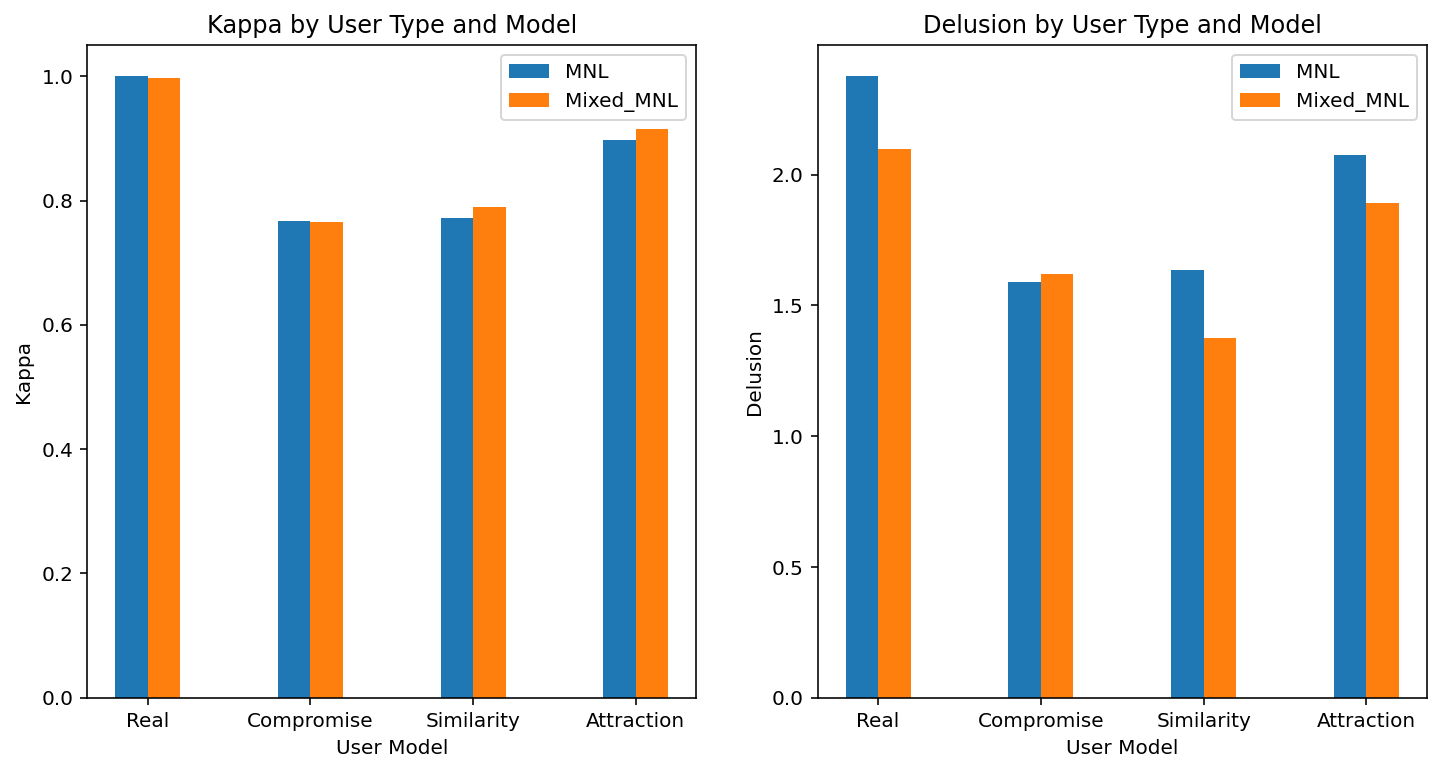

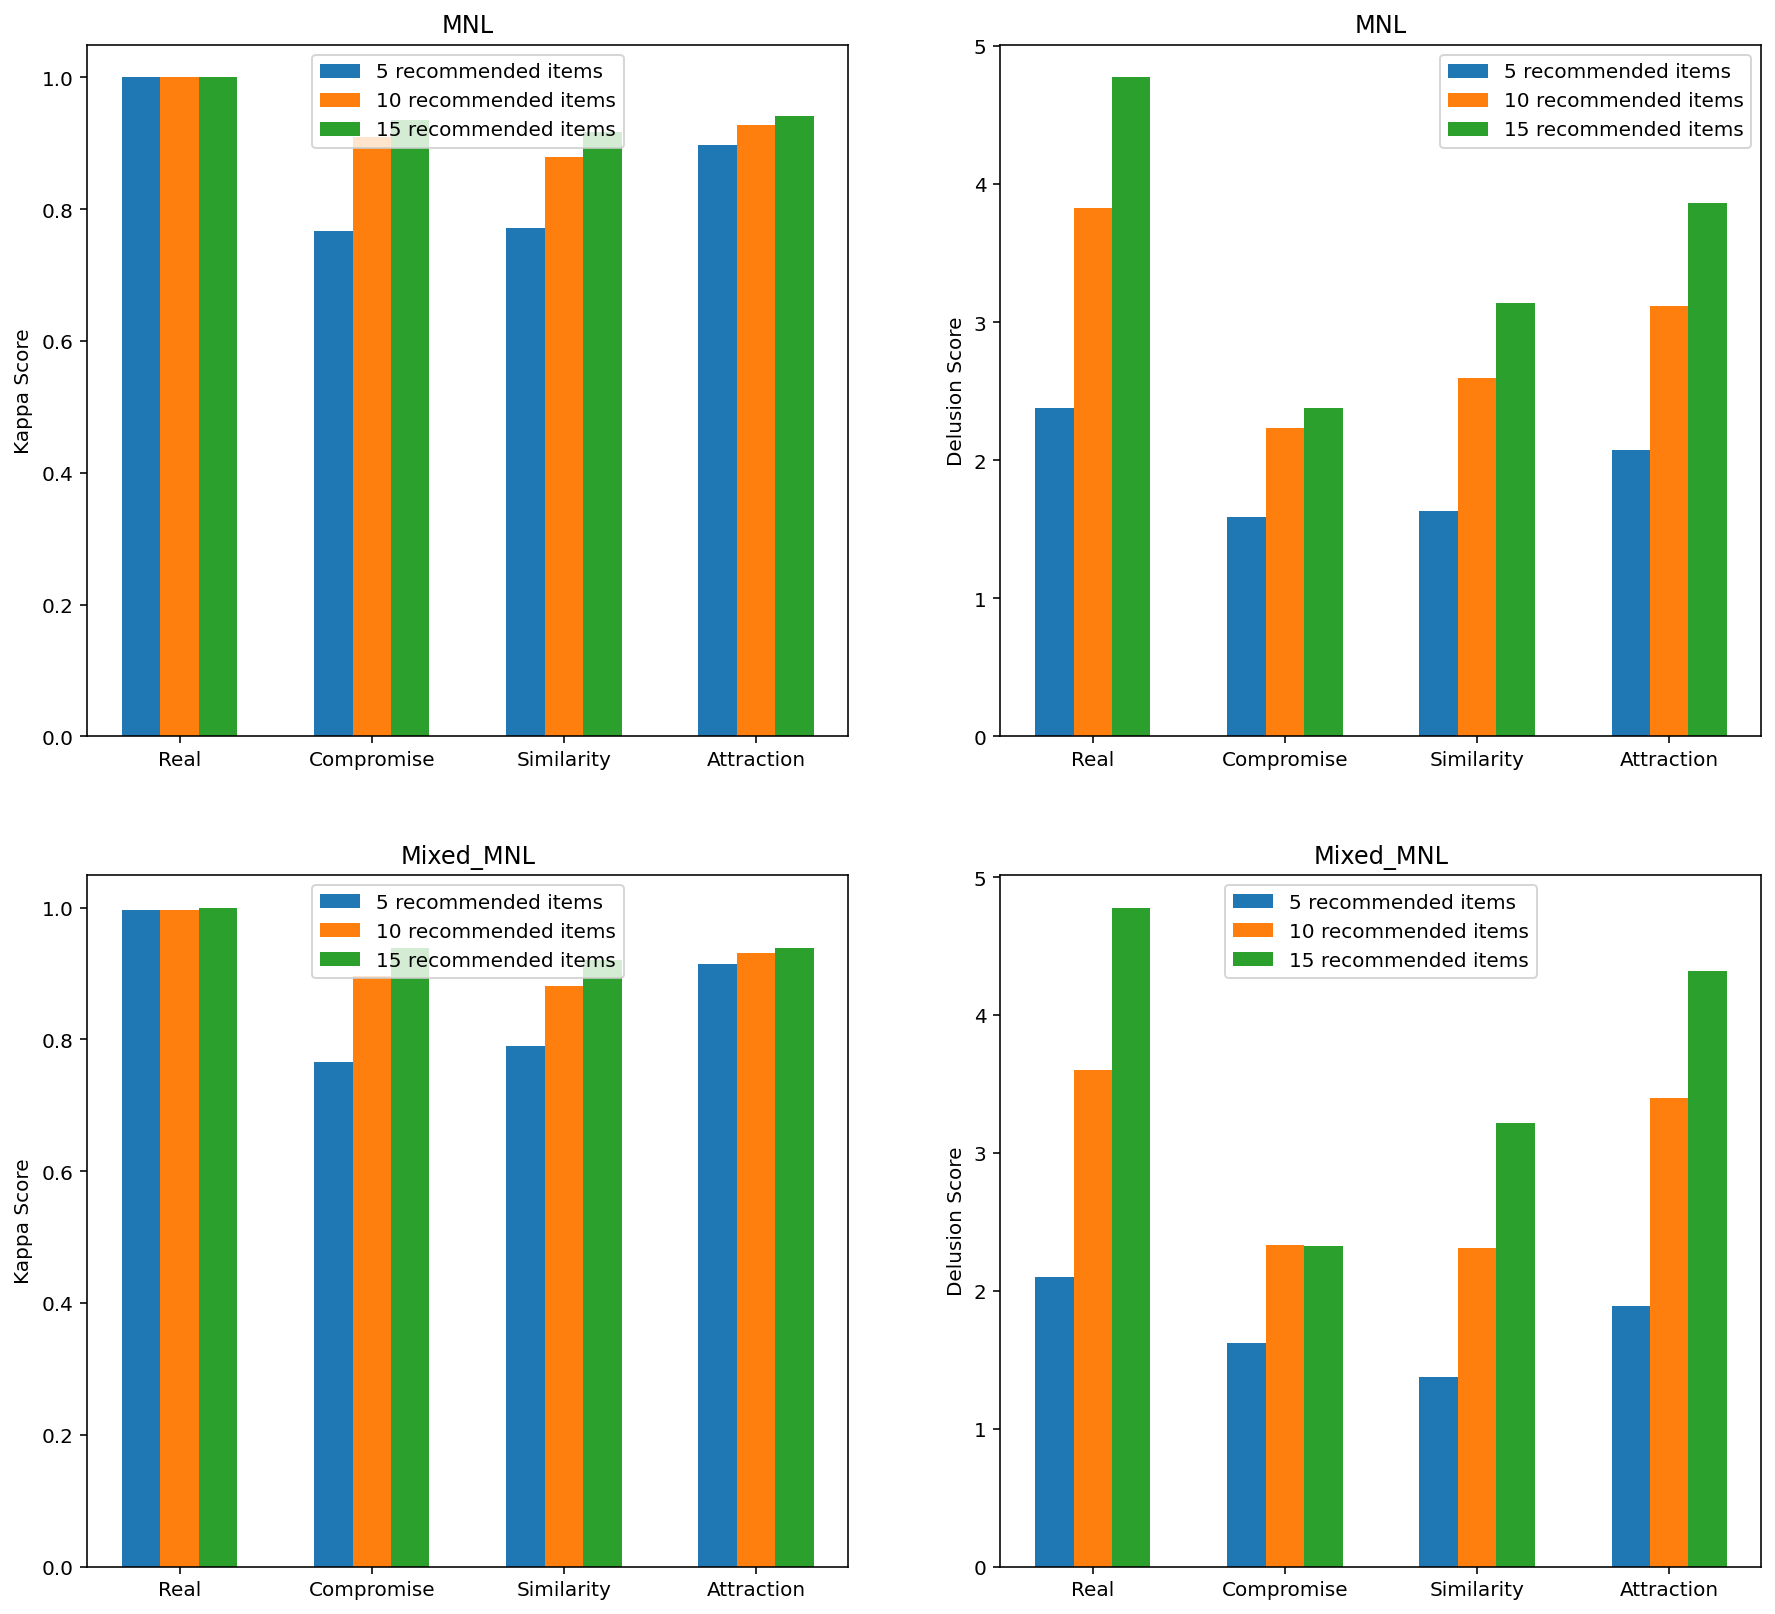

In [43]:
num_items_to_recommend_options = [5, 10, 15]
bar_plot_q4_2(learning_models, sm_env, num_items_to_recommend_options, varnames = varnames, varnames_ = varnames_)

🔵 **Answer Q4 - explaining the plots**

1. Kappa -  
    For all users, the more items we recommend, the bigger the kappa value is, for both MNL and Mixed-MNL (larger kappa -> "more IIA").This is because there's a larger ratio of items we remove who are chosen rarely and when removed, the chosen item stays the same - "contirbuting" to the IIA ratio of the slate. 
    For Real user we see a a perfect IIA behaviour with kappa = 1 regardless of number of recommended items or learning models,for the same arguments as exaplined before.

2. Delusion - 
    For both MNL and Mixed-MNL, the delusion increases with the number of recommended items. When the recommended set gets larger, it makes sense that more items with low model score will be introduced, which increases the average distance of non relevant items scores from the chosen one. 
    We can see once again, that for both MNL and Mixed-MNL and for all behavioral users, the higher the kappa is for a certain number of recommended items, the higher is the delusion score. 

## Q5 - Statistics of recommendations similarity accross models


🔴 Below we can see a statstic test we performed to further investigate the reason behind the similar outcomes of Q4 between the MNL and Mixed MNL models. 
We generate recommndations from each model: 10 items from each slate. 
we calculated the number of items from each slate that were are recommended by both of the models.  
Then we plot the distribution of this similarity ratio accross slates - we overlay scattered point representing the similarity ratio for each slate, with a violin plot representing the approximate distribution.   

Explain how the results of the produced plot help to explain the results we obtain in Q4?


In [44]:

def recommendations_statistics(recommendations_features_all_models, env):
    user_models = list(env.user_models.keys())
    total_stat = pd.DataFrame(columns=['user_model', 'slate_id', 'shared_recommendations_ratio'])
    for user in user_models:
        
        mnl_recom = recommendations_features_all_models['MNL'][user]
        mixed_mnl_recom = recommendations_features_all_models['Mixed_MNL'][user]
        
        grouped_mnl_recom, grouped_mixed_mnl_recom = mnl_recom.groupby('slate_id'), mixed_mnl_recom.groupby('slate_id')    
        for slate_id in mnl_recom['slate_id'].unique():
            mnl_slate_recom = grouped_mnl_recom.get_group(slate_id)
            mixed_mnl_slate_recom = grouped_mixed_mnl_recom.get_group(slate_id)
            
            shared_recoms = pd.merge(mnl_slate_recom, mixed_mnl_slate_recom, how='inner')
            score = len(shared_recoms) / len(mnl_slate_recom)
            
            # user_stat = pd.concat([user_stat, pd.DataFrame({'slate_id': [slate_id], 'score': [score]})])
            
            total_stat = pd.concat([total_stat, pd.DataFrame({'user_model': [user], 'slate_id': [slate_id], 'shared_recommendations_ratio': [score]})])

        # total_stat[user] = user_stat
    return total_stat 
    

In [45]:
# print(recommendations_features_all_models)
import seaborn as sns

num_items_to_recommend = 10
recommendations_features_all_models = generate_recommendations(num_items_to_recommend, trained_models, sm_env, varnames = varnames_)
stats = recommendations_statistics(recommendations_features_all_models, sm_env)


Text(0.5, 21.706249999999983, 'user model')

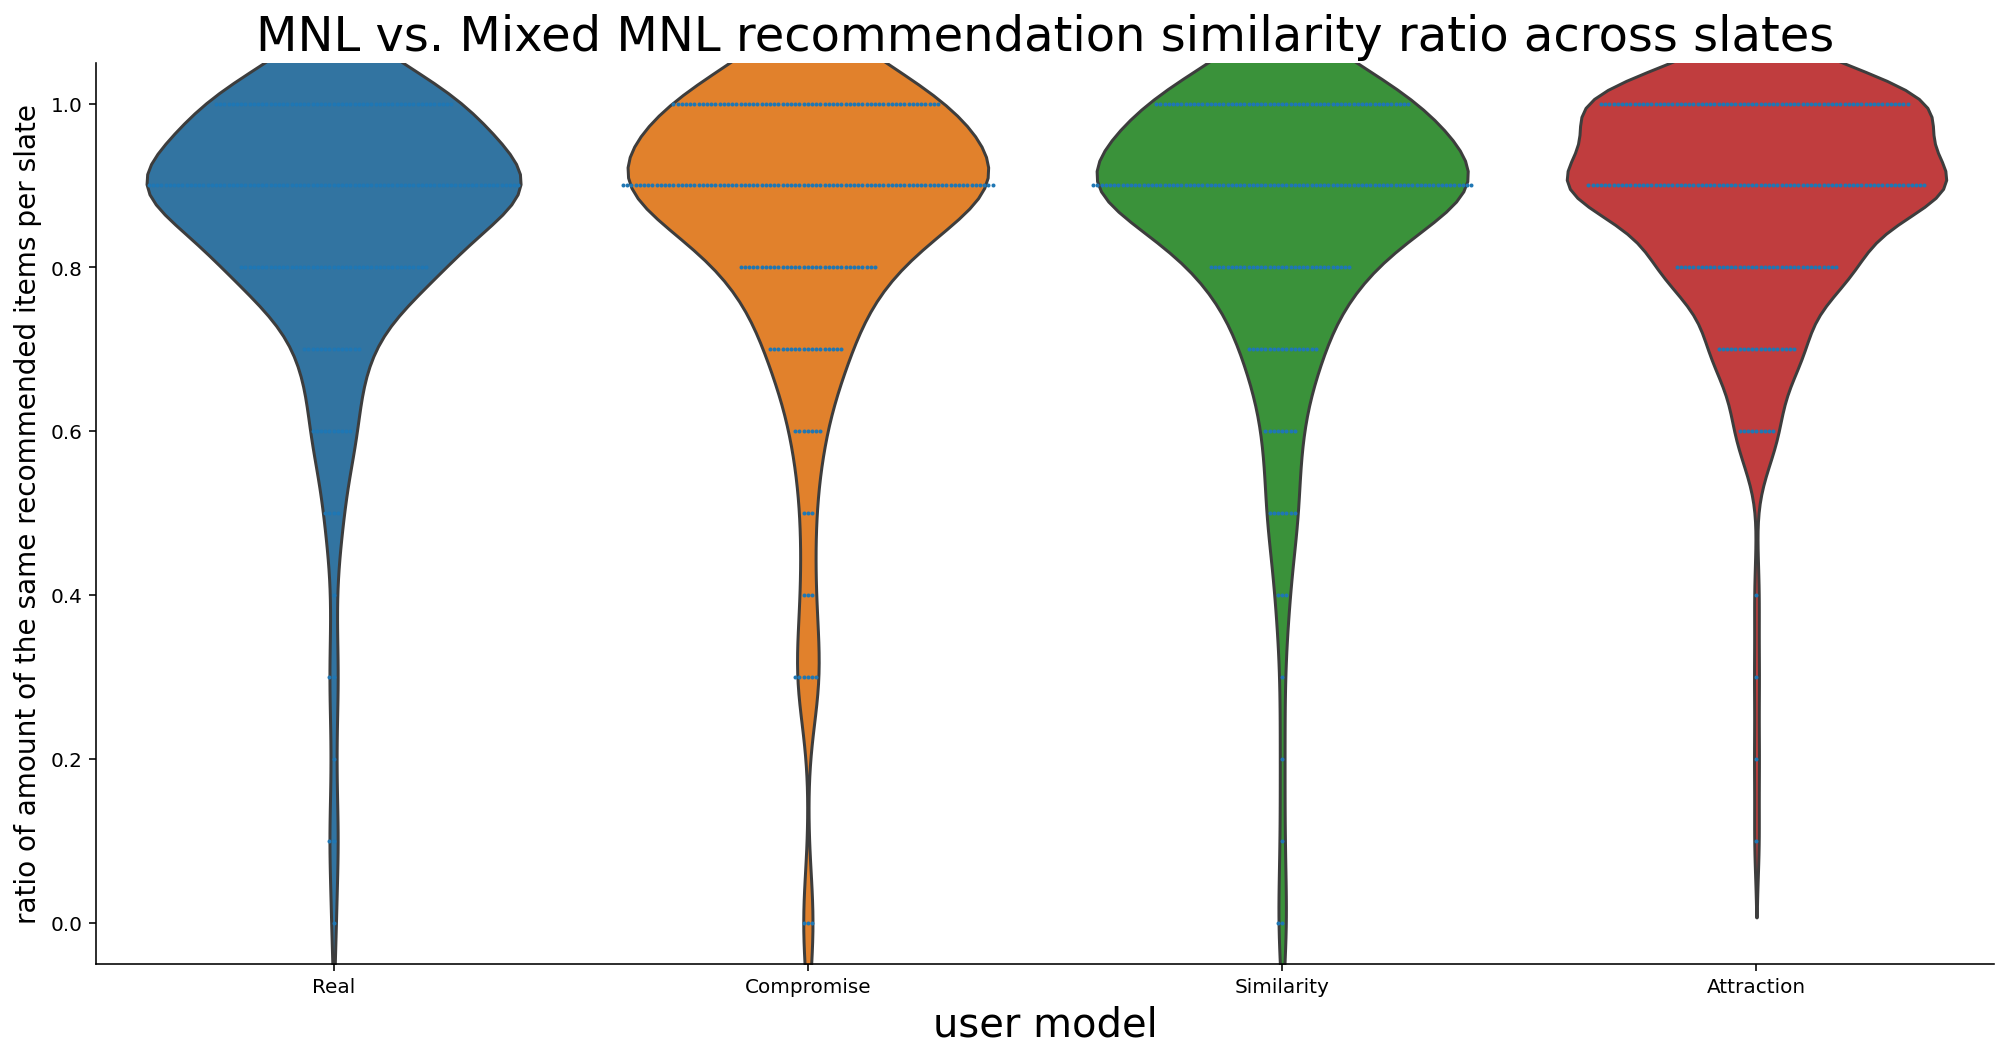

In [52]:
# fig, ax = plt.subplots()

g = sns.catplot(data=stats, x="user_model", y="shared_recommendations_ratio", kind = 'violin',inner = None, height = 7, aspect=2)
g = sns.swarmplot(data=stats, x="user_model", y="shared_recommendations_ratio", size=2)
g.set_title("MNL vs. Mixed MNL recommendation similarity ratio across slates", fontdict={'size': 24})
g.set_ylabel("ratio of amount of the same recommended items per slate", fontsize=14)
g.set_xlabel("user model", fontsize=20)
# plt.show()

🔵 **Answer Q5:** 

As we can see, most slates have a high ratio of items that are recommended by both MNL and Mixed MNL models. There are however some outlier slates with little to no shared recommended items, but overall the graph shows that the two recommendation models choose mostly the same top 10 items, which helps to explain the closeness in the kappa and delusion values calculated above.

## Part 2 Discussion:
In Mixed MNL, each user is assumed to have a unique set of preferences, represented by random coefficients that are sampled from a population distribution. The model then uses these coefficients to calculate the probability that the user will choose a particular item, given a set of candidate items. This is similar to how the MNL model works, but with the added complexity of the random coefficients.

The random coefficients in Mixed MNL allow the model to capture the heterogeneity in user preferences, which is often a limitation of simpler models like MNL. Mixed MNL model can generate more personalized recommendations that better match the user's tastes.

However, in the case where the Mixed MNL and MNL models are generating similar recommendations, it suggests that the heterogeneity in user preferences captured by the random coefficients in Mixed MNL is not significant enough to overcome the similarities between the two models. This could be due to several reasons; it is possible that the random coefficients are not providing enough additional information to the model to differentiate between the recommendations generated by Mixed MNL and MNL.

In conclusion, while Mixed MNL can capture the heterogeneity in user preferences and generate more personalized recommendations, it is not a silver bullet and may not always lead to significant improvements in recommendation performance.

# Project Summary
The project aimed to compare the recommendations made by IIA models and non IIA models; to investigate if recommendations made by IIA models cause users to behave in a more IIA manner.like MNL and svm, with non-IIA models like pairwise ranker and Mixed MNL. The study used the "kappa" measure to assess IIA behavior and a "delusion" measure to measure if this IIA behavior is a delusion caused by the model.

We started experimenting on synthetic data, on which we trained MNL and svm models, and comparing them with the pairwise ranker. We have noticed that the recommendations of pairwise ranker obtain only slightly lower kappa value(Indicating less set independent use choices).

Then we extended the study to compare between MNL and mixed MNL on real-world data (SwissMetro) The results showed no significant difference between the measures on MNL vs. Mixed MNL models, and the recommendations made by these models were usually similar. Possible reasons for this could be that users may have different preferences that cannot be captured by IIA models or that the models may not adequately capture the complexity of user behavior. 
In addition to the possible reasons mentioned earlier, another possible explanation for the lack of significant difference between the measures on IIA vs. non-IIA models could be related to the user models used to fit the models. It is possible that these user models are not flexible enough to be affected by changes in the recommender model. This could result in a situation where the recommendations made by different models do not have a noticeable effect on user behavior.




# Project Conclusions 

In the context of the experiment enviroment of the project for part 1 and part 2, we drive the follwoing conclusions:

- **Users don't(!) make more IIA choices when using an IIA model compared to non-IIA model:** From the plots produced in Q4 in both part 1 and part 2, we see that non-IIA models only slightly lower kappa values on users. 

- **User choices are IIA but the delusion factor exists:** From the plots produced in Q4 in both part 1 and part 2, we can also observe a strong correlation: the higher the kappa value the higher the delusion score as well. Meaning that the delusion is also a cause for the IIA property of the users. This was observed across all learning models. Yet, the IIA scores are relatively high, and probably not all a cause of delusion.


- **Applying (very) relaxed condition on real-world setup:** We used simple, non deep-learning-based learning models on very naive and not so flexible user models on specific datasets. Meaning our environment is far from real-life. Nevertheless, this experiment can serve as a good indicator and a ground base tool for further research.

- **Delusion Score Metric:** The delusion score we suggested helped to explain the kappa values obtained and indeed was shown by the analysis we performed to be a good indicator for the IIA delusion phenomena.



# Future Work
Further investigation could be carried out to explore the performance of other models, including hybrid models that combine different types of models to capture the complexity of user behavior. Another avenue for future research could be to incorporate more complex features into the models, such as social influence, context, and temporal dynamics. Additionally, investigating other user models that have more flexibility in chnaging bahavior based on the recommended set of items, and how user behavior changes over time and developing adaptive models that can learn and adapt to these changes could also be an interesting area of future research.
In addition, observing datasets with more clear dependencies and using more sophosticated learning models who can capture this could lead to diferent conclusions.

# References
- Benson,A.  Kumar,R , Tomkins,A: On the Relevance of Irrelevant Alternatives, https://www.cs.cornell.edu/~arb/papers/iia-www2016.pdf
- Rosenfelt,N. Oshiba,K. Singer,Y: Predicting Choice with Set-Dependent Aggregation http://proceedings.mlr.press/v119/rosenfeld20a/rosenfeld20a.pdf
- Antonini,G. Frejinger, E. et.al :Swissmetro - description of the data http://www.sze.hu/~prile/Doktori%20iskola%202018/adatok%20leiras.pdf